### Team Classy Pie
---
# ■ Shelter Animal Outcomes, 보호소 동물들의 운명 예측하기

## Contents
> ### 1. Introduction -  프로젝트 소개
> ### 2. Datasets - 데이터 소개
> ### 3. Evaluation - 평가기준
> ### 4. EDA - 탐색적 자료 분석
> ### 5. Feature Engineering - 데이터 전처리
> ### 6. Modeling - Cross Validation - 모델링 및 검증 
> ### 7. To improve performance - 성능향상을 위한 추가사항
> ### 8. Submit Kaggle and get Score - 캐글 제출 및 결과확인
> ### 9. Conclusion - 결론


---

# 1. Introduction

    
> ### 1-1. 미국의 애완동물 현황
> - 미국 가정의 약 44%가 애완 동물을 기른다.
> - 매년 미국에서 760만 마리가 아래의 이유로 보호소에 오게 된다.    
    - 주인이 원치 않음
    - 길을 잃음
    - 학대를 당함
>
>
> - 보호소에 오는 동물들이 주인을 찾아가기도 하지만 **매년 270만 마리, 약 35%는 안락사**를 당한다.
    

> ### 1-2. 프로젝트 목표
> - 미국 텍사스의 **Austin Animal Center**는 모든 동물들에게 집을 찾아주는 것을 목표
> - 동물들의 특성 데이터를 제공해서 각 동물들의 결과를 예측
> - 입양이 덜 되는 동물들에게 에너지를 쏟아 입양률을 높이기 위한 목적

---
# 2. Datasets

- 총 3개의 파일
    
> ### 2-1. Train & Test
> - 2013.10 ~ 2016.03 기간동안 보호소에 온 강아지, 고양이의 정보
>
> - train.csv : the training set
> - test.csv : the test set
    

In [1]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [177]:
print("◆ Note : 트레인 파일은 아래와 같다.")
train.tail(3)

◆ Note : 트레인 파일은 아래와 같다.


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [178]:
print("◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.")
test.tail(3)

◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.


,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11453,11454,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40:00,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [179]:
print(train.shape)

(26729, 10)


- Train data의 컬럼
    - OutcomeType (예측해야할 target 값)
    - OutcomeSubtype (OutcomeType과 연계된 부가정보)
    - +Test data의 컬럼들
- Test data의 컬럼
    - AnimalID(중복되지않는 고유 ID)
    - Name(이름이 없는 경우가 많음)
    - DateTime(Outcome이 발생한 날짜기록)
    - AnimalType(강아지, 고양이)
    - SexuponOutcome(성별 및 중성화여부, 5가지)
    - AgeuponOutcome(동물의 나이)
    - Breed(종)
    - Color(색상)

> ### 2-2. Submission
> - sample_submission.csv : a sample submission file in the correct format
    - 모든 동물들이 떠날때 클래스별 예측 확률

--- 
# 3. Evalutaion

    Submissions are evaluated using the multi-class logarithmic loss.
    
    where N is the number of animals in the test set, M is the number of outcomes
    log is the natural logarithm
    yij is 1 if observation i is in outcome j and 0 otherwise
    pij is the predicted probability that observation i belongs to outcome j.
    


$ \Large -\frac{1}{N} \sum \sum y_{ij}log(p_{ij}) $

---
# 4. EDA & Feature Engineering

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

## 4-1. raw data Analysis & Explore

In [181]:
print('-- 데이터 간략정보 --')
train.describe().T

-- 데이터 간략정보 --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


In [182]:
print("-- 컬럼별 null의 갯수 --")
pd.DataFrame(train.isnull().sum())

-- 컬럼별 null의 갯수 --


,0
AnimalID,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,18
Breed,0
Color,0


In [183]:
print('-- 중복자료 및 unique --')
train.describe().T

-- 중복자료 및 unique --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


-- OutcomeType의 내용 --


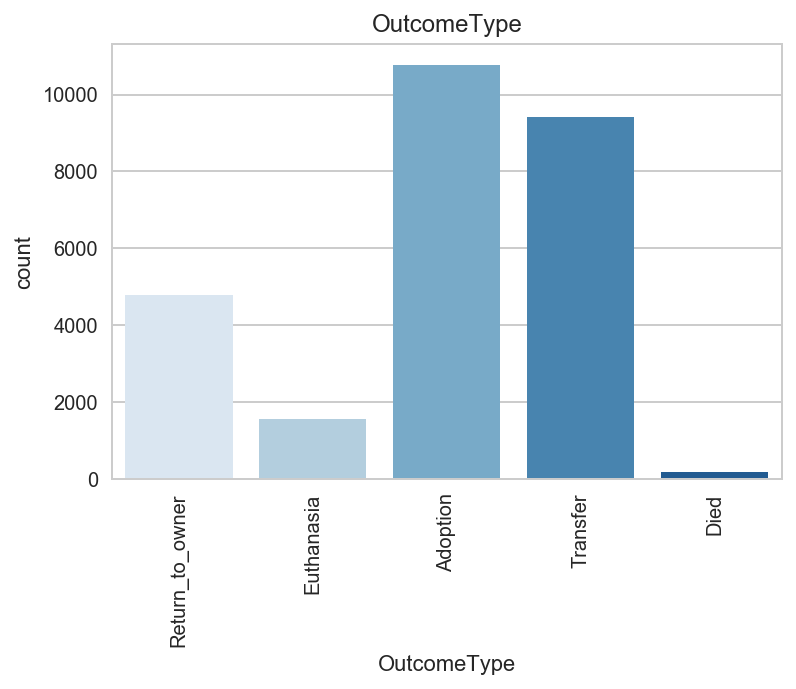

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [184]:
print("-- OutcomeType의 내용 --")
sns.countplot(x=train["OutcomeType"], data=train , palette="Blues")
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show()
train["OutcomeType"].value_counts()

In [185]:
print("-- OutcomeSubtype의 내용 --")
train.groupby("OutcomeSubtype").size().reset_index(name='count').sort_values('count', ascending=False)

-- OutcomeSubtype의 내용 --


,OutcomeSubtype,count
12,Partner,7816
6,Foster,1800
14,SCRP,1599
15,Suffering,1002
0,Aggressive,320
11,Offsite,165
8,In Kennel,114
3,Behavior,86
13,Rabies Risk,74
10,Medical,66


In [186]:
print("-- AnimalType의 내용 --")
train.groupby("AnimalType").size().reset_index(name='count').sort_values('count',ascending=False)

-- AnimalType의 내용 --


,AnimalType,count
1,Dog,15595
0,Cat,11134


In [187]:
print("-- SexuponOutcome의 내용 --")
train.groupby("SexuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False)

-- SexuponOutcome의 내용 --


,SexuponOutcome,count
2,Neutered Male,9779
3,Spayed Female,8820
1,Intact Male,3525
0,Intact Female,3511
4,Unknown,1093


In [188]:
print("-- AgeuponOutcome의 내용 --")
print("     - ※10개만 표시하고 중략")
train.groupby("AgeuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False).head(10)

-- AgeuponOutcome의 내용 --
     - ※10개만 표시하고 중략


,AgeuponOutcome,count
5,1 year,3969
21,2 years,3742
19,2 months,3397
26,3 years,1823
2,1 month,1281
24,3 months,1277
30,4 years,1071
34,5 years,992
28,4 months,888
37,6 years,670


In [189]:
print("-- Breed의 내용 --")
print("     - 15개 항목만 표시하고 중략")
train.groupby("Breed").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Breed의 내용 --
     - 15개 항목만 표시하고 중략


,Breed,count
640,Domestic Shorthair Mix,8810
1066,Pit Bull Mix,1906
450,Chihuahua Shorthair Mix,1766
847,Labrador Retriever Mix,1363
637,Domestic Medium Hair Mix,839
696,German Shepherd Mix,575
632,Domestic Longhair Mix,520
1251,Siamese Mix,389
74,Australian Cattle Dog Mix,367
559,Dachshund Mix,318


In [190]:
print("-- Color의 내용 --")
print("    - 15개 항목만 표시하고 중략")
train.groupby("Color").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Color의 내용 --
    - 15개 항목만 표시하고 중략


,Color,count
38,Black/White,2824
5,Black,2292
104,Brown Tabby,1635
111,Brown Tabby/White,940
318,White,931
130,Brown/White,884
216,Orange Tabby,841
289,Tan/White,773
307,Tricolor,752
86,Blue/White,702


### NaN값 처리

In [368]:
# 나이정보가 없는 경우 10여 종류
train[train["AgeuponOutcome"].isnull() == True]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
2480,A720674,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White
2912,A720973,NaN,2016-02-18 19:07:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Gray Tabby
3766,A720820,NaN,2016-02-16 18:55:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby
3875,A721076,NaN,2016-02-20 16:37:00,Euthanasia,Suffering,Dog,Intact Male,NaN,Toy Poodle Mix,White
4498,A720422,NaN,2016-02-09 19:43:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby
5137,A720697,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Spayed Female,NaN,Domestic Shorthair Mix,Black
5691,A720640,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black Tabby/White
7005,A720636,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black
8420,A720701,NaN,2016-02-16 10:16:00,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White
17464,A720782,NaN,2016-02-16 18:55:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Torbie


In [3]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
train["OutcomeSubtype"] = train["OutcomeSubtype"].fillna("NoStatus")
train["SexuponOutcome"] = train["SexuponOutcome"].fillna("Unknown")
train["AgeuponOutcome"] = train["AgeuponOutcome"].fillna("-1 nodata")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")


## 4-2. Feature Engineering & Analysis

### - 비정형 데이터 --> 반정형화(정리) --> 정형화(OHE,Categorizing)

In [5]:
# 전처리함수(수정가능)---------------
import datetime as dt


def preprocessShelter(df_raw):
    df = df_raw.copy()
    # Name --> Isname------------------------------------------
    df['Name'].fillna('Unknown', inplace=True)

    # 이름이 있으면 Has_name, 이름이 없으면 Unknown------------
    name = []
    for i in df['Name']:
        if i == 'Unknown':
            name.append('Unknown_name')
        else:
            name.append('Has_name')
    df['Name'] = name
    
    
    # color정리 - black, white, brown, others로 나눔
#     color = []
#     for i in df['Color']:
#         if i[:5] == 'Black':
#             color.append('Black')
#         elif i[:5] == 'White':
#             color.append('White')
#         elif i[:5] == 'Brown':
#             color.append('Brown')
#         else:
#             color.append('C_Others')
#     df['Color_1st'] = color    
    
    #--------------------------------------------1차 추가되는 컬럼정리(나이, 성별)
    
    df["sex_intact"] = (df["SexuponOutcome"].str.slice(0,6) == "Intact").astype(int)
    df["sex_unknown"] = (df["SexuponOutcome"] == "Unknown").astype(int)
    df["sex_mf"] = (df["SexuponOutcome"].str.split(' ', n=2, expand=True)[1] == "Male").astype(int)
    df.sex_mf[df["sex_unknown"]==1] = 2
    df.sex_intact[df["sex_unknown"]==1] = 2
    
    # 나이데이터 재정리 (Agenbr=나이의숫자만, Age_tscale=(day,week,month,year), Age_yscale=동물의 연생, 
    df["Age_nbr"] = df["AgeuponOutcome"].str.slice(0,2).astype(int) # 0인값의경우 해당 동물의 나이정보가 없는것으로 추정한다
    df["Age_tscale"] = df["AgeuponOutcome"].str.split(" ", n=2, expand=True)[1] # 띄어쓰기 된 뒷문장 가져오기
    df["Age_tscale"] = df["Age_tscale"].replace("s","",regex=True) # 문자 s를 삭제
    df["Age_yscale"] = df["Age_tscale"].replace(["day","week","month"],"under_year")
    df["Age_ynbr"] = df["Age_nbr"].copy()
    df.Age_ynbr[df["Age_yscale"]=="under_year"] = 0
    
    df["Age_daily_scale"] = 0
    df.Age_daily_scale[df['Age_tscale']=="day"] = 1
    df.Age_daily_scale[df['Age_tscale']=="week"] = 7
    df.Age_daily_scale[df['Age_tscale']=="month"] = 30
    df.Age_daily_scale[df['Age_tscale']=="year"] = 365
    df["Age_daily_scale"] = df["Age_daily_scale"]*df["Age_nbr"]

    # 어린친구, 성체, 나이든친구
    df["Age_code"] = 0
    df.Age_code[(df['Age_ynbr']>=1)|(df['Age_ynbr']<=3)] = 1
    df.Age_code[(df['Age_ynbr']>=4)] = 2
    
    # Breed 정제 - 1차 - 김민우
    df["Breed_Do"] = 0
    df["Breed_Mx"] = 0
    df["Breed_Lh"] = 0
    df["Breed_Mh"] = 0
    df["Breed_Sh"] = 0
    df["Breed_dogM"] = 0
    df.Breed_Do[df['Breed'].str.contains("Domestic", regex=True)] = 1
    df.Breed_Mx[df['Breed'].str.contains("Mix", regex=True)] = 1
    df.Breed_Lh[df['Breed'].str.contains("Longhair", regex=True)] = 1
    df.Breed_Sh[df['Breed'].str.contains("Shorthair", regex=True)] = 1
    df.Breed_Mh[df['Breed'].str.contains("MediumHair", regex=True)] = 1
    df.Breed_dogM[df['Breed'].str.contains("/", regex=True)] = 1
    df["Breed_extra"] = df["Breed"].replace(["Domestic","Mix"," ","Shorthair","Longhair","MediumHair",""],"",regex=True) # 문자 s를 삭제

    df["Breed_Pitbull"] = df["Breed_extra"].str.contains("PitBull",regex=True)

    # Breed 정제 - 2차 -정혜란님 아이디어
#     df["Breed_Sheepdog"] = 0 #쉐퍼드견 포함
#     df["Breed_Terrier"] = 0
#     df["Breed_Hound"] = 0
    
#     df["Breed_Chihuahua"] = 0
#     df["Breed_Pitbull"] = 0
#     df["Breed_Retriver"] = 0
#     df["Breed_Bullbog"] = 0
#     df["Breed_Poodle"] = 0
    
#     df["Breed_English"] = 0
#     df["Breed_American"] = 0
#     df["Breed_Chinese"] = 0
#     df["Breed_German"] = 0
#     df["Breed_OtherNT"] = 0
    


    # 시간데이터 정제
    temp = pd.to_datetime(df['DateTime'])
    df["Time_year"] = temp.dt.strftime("%Y").astype(int)
    df["Time_month"] = temp.dt.strftime("%m").astype(int)
    df["Time_DOW"] = temp.dt.dayofweek.astype(int)
    df["Time_day"] = temp.dt.strftime("%d").astype(int)
    df["Time_hour"] = temp.dt.strftime("%H").astype(int)
    df["Time_weekend"] = (df['Time_DOW'] >= 5).astype(int)
    df["Time_operating"] = 0
    df.Time_operating[(df['Time_hour']>=5)|(df['Time_hour']<=10)] = 1
    df.Time_operating[(df['Time_hour']>=11)|(df['Time_hour']<=15)] = 2
    df.Time_operating[(df['Time_hour']>=16)|(df['Time_hour']<=18)] = 3
    df.Time_operating[df['Time_hour']==19] = 4
    
    df["Time_season"] = ((df["Time_month"]%12)//3).astype(int)
    
    
    # 미 텍사스주 공휴일
    
    df["Holidays"] = 0
    df.Holidays[(df['Time_month']==1)&(df['Time_day']==19)]=1
    df.Holidays[(df['Time_month']==3)&(df['Time_day']==2)]=2
    df.Holidays[(df['Time_month']==4)&(df['Time_day']==21)]=3
    df.Holidays[(df['Time_month']==5)&(df['Time_day']==10)]=4
    df.Holidays[(df['Time_month']==6)&(df['Time_day']==19)]=5
    df.Holidays[(df['Time_month']==6)&(df['Time_day']>=18)&(df['Time_day']<=22)]=6
    df.Holidays[(df['Time_month']==8)&(df['Time_day']==27)]=7
    df.Holidays[(df['Time_month']==11)&(df['Time_day']==11)]=8
    df.Holidays[(df['Time_month']==11)&(df['Time_day']>=25)&(df['Time_day']<=27)]=9
    df.Holidays[(df['Time_month']==12)&(df['Time_day']>=23)&(df['Time_day']<=27)]=10
    
    return df

def preprocessColorBreed(df):
    
    #Breed 정제 2차 - 전현일
    df_B = pd.DataFrame()
    ls = [i for data in list(df["Breed_extra"]) for i in data.split("/") ]
    breeds = np.unique(ls)
    for i in breeds[1:]:
        df_B[i] = df['Breed_extra'].str.contains(i, regex=True).astype(int)
    
    #Color 정제 2차 - 정혜란, 전현이
    df_C = pd.DataFrame()
    
    df_C["Color_mix"] = df["Color"].copy()
    df_C["Color_mix"] = 1
    df_C.Color_mix[df["Color"].str.contains("/|Sable|Seal Point|Lilac Point", regex=True)==True] = 2
    df_C.Color_mix[df["Color"].str.contains("Tricolor|Calico|Tortie|Torbie", regex=True)==True] = 3
    
    df_C["Color_extra"] = df["Color"].str.contains("Cream|Buff|Fawn|Apricot|Flame Point", regex=True).astype(int)
    df_C["Color_ful"] = df["Color"].str.contains("Blue|Red|Green", regex=True).astype(np.int8)
    df_C["Color_black"] = df["Color"].str.contains("Black", regex=True).astype(np.int8)
    df_C["Color_white"] = df["Color"].str.contains("White", regex=True).astype(np.int8)
    df_C["Color_gray"] = df["Color"].str.contains("Lynx|Gray|Silver", regex=True).astype(np.int8)
    df_C["Color_gold"] = df["Color"].str.contains("Orange|Yellow|Gold", regex=True).astype(np.int8)
    df_C["Color_brown"] = df["Color"].str.contains("Brown|Tan|Chocolate", regex=True).astype(np.int8)

    
    return df_C, df_B #, breeds


#--------아래는 All카테고라이저, All원핫인코더 함수-------

from sklearn.preprocessing import LabelEncoder
def allCategorizer(df, columns=[]):

    print("Categorizing start... using ", columns)
    
    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
    
    temp = df[col_name].copy()
    
    for i in range(col_num):
        le = LabelEncoder()
        y = temp[col_name[i]]
        le.fit(y)
        temp[col_name[i]] = le.transform(y)
        print(i,", ",end="")
    print("Complete!")
    return temp.astype(np.int8)        
        
def allOneHotEncoder(df, columns=[]):
    print("One_Hot_Encoding start... using ", columns)

    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
        
    for i in range(col_num):
        temp = pd.get_dummies(df[col_name[i]])
        if i == 0 : 
            onehot_df = temp.copy()
            print(i,", ",end="")
        else : 
            onehot_df = pd.concat([onehot_df,temp], axis=1)
            print(i,", ",end="")
    print("Complete!")
    return onehot_df



# 전처리된 데이터프레임 설정 --> df_train -------------------

df_train = preprocessShelter(train)
df_colors, df_breeds = preprocessColorBreed(df_train)

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [ ]:
print(df_train.columns,"\n")
print(df_breeds.columns,"\n")
print(df_colors.columns)
df_train.describe().T


In [14]:
# 전처리 2단계 -- 카테고리화 및 One Hot Encoding
# cols= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']
cols2=['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf',
       'Age_daily_scale', 'Age_code',
       'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Breed_Pitbull'
       'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
       'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']

df_OHE = allOneHotEncoder(df_train,cols2)
df_Ctg = allCategorizer(df_train,cols2)
# temp.head(20)
# df_train[cols]
df_filted = pd.concat([df_Ctg,df_breeds,df_colors],axis=1)
len(df_filted.columns)

One_Hot_Encoding start... using  ['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_daily_scale', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , Complete!
Categorizing start... using  ['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_daily_scale', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , Complete!


251

In [ ]:
# df_filted.tail()
df_train.tail()

In [356]:
# 전처리 3단계 - 견종/묘종 특징 분류
# list(df_breeds.columns)
# breeds[:75] - 정혜란 조사
# breeds[75:150] - 전현일 조사
# breeds[150:] - 김민우 조사

Breed_dev = pd.DataFrame(columns=["Breed_extra","Breed_Life","Breed_Size",
                                  "Breed_Acti","Breed_Smrt","Breed_Fmly","Breed_Agve"])
Breed_dev["Breed_extra"] = ['Pbgv', 'Pekingese', 'PembrokeWelshCorgi', 'Persian',
       'PharaohHound', 'PicardySheepdog', 'PitBull', 'Pixiebob',
       'PlottHound', 'PodengoPequeno', 'Pointer', 'Pomeranian',
       'PortWaterDog', 'PresaCanario', 'Pug', 'QueenslandHeeler',
       'Ragdoll', 'RatTerrier', 'RedboneHound', 'Rex', 'RhodRidgeback',
       'Rottweiler', 'RussianBlue', 'Saluki', 'Samoyed', 'Schipperke',
       'SchnauzerGiant', 'ScottishTerrier', 'SealyhamTerr',
       'ShetlandSheepdog', 'ShibaInu', 'ShihTzu', 'Siamese',
       'SiberianHusky', 'SilkyTerrier', 'SkyeTerrier', 'SmoothFoxTerrier',
       'Snowshoe', 'SoftCoatedWheatenTerrier', 'SpanishMastiff',
       'SpanishWaterDog', 'Sphynx', 'SpinoneItaliano',
       'St.BernardRoughCoat', 'St.BernardSmoothCoat', 'Staffordshire',
       'StandardPoodle', 'StandardSchnauzer', 'SwedishVallhund',
       'SwissHound', 'TanHound', 'TibetanSpaniel', 'TibetanTerrier',
       'Tonkinese', 'ToyFoxTerrier', 'ToyPoodle', 'TreeingCur',
       'TreeingTennesseBrindle', 'TreeingWalkerCoonhound', 'TurkishVan',
       'Unknown', 'Vizsla', 'Weimaraner', 'WelshSpringerSpaniel',
       'WelshTerrier', 'WestHighland', 'Whippet', 'WireHairFoxTerrier',
       'WirehairedPointingGriffon', 'Yorkshire', 'YorkshireTerrier']

Breed_dev["Breed_Life"] = [13,14,13,14,13,13,11,13,13,14,13,14,14,10,14,14,15,17,12,14,11,9,17,13,13,14,14,14,13,13,14,14,11,14,14,14,14,14,14,12,14,13,9,9,12,14,15,14,13,11,14,14,14,13,15,14,14,11,13,15,0,14,11,14,14,14,14,13,11,15,15] #수명
Breed_dev["Breed_Size"] = [2,1,2,1,3,3,2,1,3,1,3,0,2,3,1,2,1,1,3,1,3,3,0,2,2,1,3,1,1,1,1,1,1,2,1,2,1,1,2,3,3,1,3,3,3,3,3,2,2,2,3,1,2,1,0,0,2,2,3,1,4,3,3,2,1,1,2,1,3,0,0] #크기(0,1,2,3단계-[4kg미만, 10kg미만, 25kg미만, 25kg이상])
Breed_dev["Breed_Acti"] = [1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,1] #활동성
Breed_dev["Breed_Smrt"] = [0,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,1,1,1] #영리함
Breed_dev["Breed_Fmly"] = [1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,0,1,1,0,1,1,1,0,0] #사교성, 충성심
Breed_dev["Breed_Agve"] = [0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0] #공격성 (pitbull류)
Breed_dev.tail(20)


,Breed_extra,Breed_Life,Breed_Size,Breed_Acti,Breed_Smrt,Breed_Fmly,Breed_Agve
51,TibetanSpaniel,14,1,1,1,0,0
52,TibetanTerrier,14,2,1,0,1,0
53,Tonkinese,13,1,1,0,1,0
54,ToyFoxTerrier,15,0,1,0,1,0
55,ToyPoodle,14,0,1,1,0,0
56,TreeingCur,14,2,0,0,1,0
57,TreeingTennesseBrindle,11,2,0,1,1,0
58,TreeingWalkerCoonhound,13,3,0,1,1,0
59,TurkishVan,15,1,1,1,1,0
60,Unknown,0,4,0,0,0,0


In [85]:
Breed_dev = pd.DataFrame(columns=["Breed_extra","Breed_Life","Breed_Size",
                                  "Breed_Acti","Breed_Smrt","Breed_Fmly","Breed_Agve"])
Breed_dev["Breed_extra"] = ['Abyssinian','Angora','Affenpinscher', 'AfghanHound', 'AiredaleTerrier',
       'Akita', 'AlaskanHusky', 'AlaskanMalamute',
       'AmericanBulldog', 'AmericanEskimo', 'AmericanFoxhound',
       'AmericanPitBullTerrier', 'AmericanStaffordshireTerrier',
       'AnatolShepherd', 'AustralianCattleDog',
       'AustralianKelpie', 'AustralianShepherd', 'AustralianTerrier',
       'Balinese', 'Basenji', 'BassetHound', 'Beagle', 'BeardedCollie',
       'Beauceron', 'BedlingtonTerr', 'BelgianMalinois', 'BelgianSheepdog',
       'BelgianTervuren', 'Bengal', 'BerneseMountainDog', 'BichonFrise',
       'BlackMouthCur', 'Bloodhound', 'BlueLacy', 'BluetickHound',
       'Boerboel', 'Bombay', 'BorderCollie', 'BorderTerrier', 'Borzoi',
       'BostonTerrier', 'Boxer', 'BoykinSpan', 'Brittany',         
       'BrussGriffon', 'BullTerrier', 'BullTerrierMiniature', 'Bulldog',
       'Bullmastiff', 'Burmese', 'CairnTerrier', 'CanaanDog', 'CaneCorso',
       'CardiganWelshCorgi', 'CarolinaDog', 'Catahoula', 'CavalierSpan',     
       'ChesaBayRetr', 'Chihuahua', 'ChineseCrested', 'ChineseSharpei',    
       'ChowChow', 'CockerSpaniel', 'CollieRough', 'CollieSmooth',
       'CornishRex', 'Cymric', 'Dachshund', 'DachshundWirehair',
       'Dalmatian', 'DevonRex', 'DobermanPinsch', 'DogoArgentino', 'DogueDeBordeaux',
       'DutchShepherd', 'EnglishBulldog', 'EnglishCockerSpaniel',
       'EnglishCoonhound', 'EnglishFoxhound', 'EnglishPointer',
       'EnglishSetter', 'EnglishShepherd', 'EnglishSpringerSpaniel',
       'Entlebucher', 'Exotic', 'Feist', 'FieldSpaniel', 'FinnishSpitz',
       'FlatCoatRetriever', 'FrenchBulldog', 'GermanPinscher',
       'GermanPointer', 'GermanShepherd', 'GermanWirehairedPointer',
       'GlenOfImaal', 'GoldenRetriever', 'GreatDane', 'GreatPyrenees',
       'GreaterSwissMountainDog', 'Greyhound', 'Harrier', 'HavanaBrown',
       'Havanese', 'Himalayan', 'Hovawart', 'IbizanHound', 'IrishSetter',
       'IrishTerrier', 'IrishWolfhound', 'ItalianGreyhound',
       'JackRussellTerrier', 'JapaneseBobtail', 'JapaneseChin', 'Javanese',
       'Jindo', 'Keeshond', 'Kuvasz', 'LabradorRetriever', 'Landseer',
       'Leonberger', 'LhasaApso', 'Lowchen', 'MaineCoon', 'Maltese',
       'ManchesterTerrier', 'Manx', 'Mastiff', 'MexicanHairless',
       'MiniaturePinscher', 'MiniaturePoodle', 'MiniatureSchnauzer',
       'Munchkin', 'NeapolitanMastiff', 'Newfoundland', 'NorfolkTerrier',
       'NorwegianElkhound', 'NorwegianForestCat', 'NorwichTerrier',
       'NovaScotiaDuckTollingRetriever', 'Ocicat', 'OldEnglishBulldog',
       'OldEnglishSheepdog', 'Otterhound', 'Papillon',
       'ParsonRussellTerrier', 'PatterdaleTerr',
       'Pbgv', 'Pekingese', 'PembrokeWelshCorgi', 'Persian',
       'PharaohHound', 'PicardySheepdog', 'PitBull', 'Pixiebob',
       'PlottHound', 'PodengoPequeno', 'Pointer', 'Pomeranian',
       'PortWaterDog', 'PresaCanario', 'Pug', 'QueenslandHeeler',
       'Ragdoll', 'RatTerrier', 'RedboneHound', 'Rex', 'RhodRidgeback',
       'Rottweiler', 'RussianBlue', 'Saluki', 'Samoyed', 'Schipperke',
       'SchnauzerGiant', 'ScottishTerrier', 'SealyhamTerr',
       'ShetlandSheepdog', 'ShibaInu', 'ShihTzu', 'Siamese',
       'SiberianHusky', 'SilkyTerrier', 'SkyeTerrier', 'SmoothFoxTerrier',
       'Snowshoe', 'SoftCoatedWheatenTerrier', 'SpanishMastiff',
       'SpanishWaterDog', 'Sphynx', 'SpinoneItaliano',
       'St.BernardRoughCoat', 'St.BernardSmoothCoat', 'Staffordshire',
       'StandardPoodle', 'StandardSchnauzer', 'SwedishVallhund',
       'SwissHound', 'TanHound', 'TibetanSpaniel', 'TibetanTerrier',
       'Tonkinese', 'ToyFoxTerrier', 'ToyPoodle', 'TreeingCur',
       'TreeingTennesseBrindle', 'TreeingWalkerCoonhound', 'TurkishVan',
       'Unknown', 'Vizsla', 'Weimaraner', 'WelshSpringerSpaniel',
       'WelshTerrier', 'WestHighland', 'Whippet', 'WireHairFoxTerrier',
       'WirehairedPointingGriffon', 'Yorkshire', 'YorkshireTerrier',
        '', 'American', 'Black', 'British']
 
Breed_dev["Breed_Life"] = [12,11.5,13,15,12.5,11.5,12.5,12,12.5,14,12,11.5,14,12,14,11.5,13.5,13,20,13.5,12.5,12.5,13,11,13.5,15,13,13,11.5,\
                          8.5,14.5,15,11,16,11.5,10,17,13.5,13.5,11.5,12,11,12.5,13,13.5,12.5,12,9,8,13.5,14,13.5,10.5,13.5,13.5,12,\
                          13.5,11.5,15,15.5,10,10,12,13,13,11.5,12,14,14,12,12.5,
                          11, 11, 6.5, 12.5, 9, 13, 11.5, 11.5, 13, 12, 15, 13, 13, 13, 11.5, 12.5, 14, 9, 11, 13, 11, 8.5, 15, 12.5, 11, 8.5, 11, 9.5, 11.5, 13.5, 12.5, 15, 9.5, 12, 12.5, 13.5, 14, 7, 14.5, 14.5, 11, 11, 10, 13.5, 13.5, 11, 11, 9, 7, 13.5, 14, 12, 13.5, 16, 11, 8, 13.5, 14, 13.5, 13.5, 14, 8, 9.5, 14, 13.5, 11, 13.5, 13, 12.5, 12, 11, 11.5, 15, 14, 13.5,
                          1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,1,
                          11,11,11,11] #수명
Breed_dev["Breed_Size"] = [1,1,1,3,3,3,2,3,3,2,3,1,3,3,2,3,2,1,0,2,2,2,2,3,1,3,3,3,1,3,1,2,3,2,3,3,0,2,1,3,1,3,2,2,1,3,2,2,3,1,1,2,2,2,2,3,1,3,0,1,2,3,2,3,3,0,1,1,1,3,0,
                          3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 2, 3, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 3, 2, 1, 1, 1, 0, 3, 3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 0, 1, 1,
                          2,1,2,1,3,3,2,1,3,1,3,0,2,3,1,2,1,1,3,1,3,3,0,2,2,1,3,1,1,1,1,1,1,2,1,2,1,1,2,3,3,1,3,3,3,3,3,2,2,2,3,1,2,1,0,0,2,2,3,1,4,3,3,2,1,1,2,1,3,0,0,
                          4,4,4,4] #크기(0,1,2,3단계-[4kg미만, 10kg미만, 25kg미만, 25kg이상, 알수없음])
Breed_dev["Breed_Acti"] = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,2,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
                          1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
                          1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,1,
                          2,2,2,2] #활동성
Breed_dev["Breed_Smrt"] = [1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,
                          1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
                          0,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,1,1,1,
                          2,2,2,2] #영리함
Breed_dev["Breed_Fmly"] = [0,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,
                          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                          1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                          0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                          0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,
                          2,2,2,2] #공격성 (pitbull류)
                 
Breed_dev.tail()


,Breed_extra,Breed_Life,Breed_Size,Breed_Acti,Breed_Smrt,Breed_Fmly,Breed_Agve
212,Whippet,0.0,2,0,1,1,0
213,WireHairFoxTerrier,1.0,1,1,0,1,0
214,WirehairedPointingGriffon,0.0,3,0,1,1,0
215,Yorkshire,1.0,0,1,1,0,0
216,YorkshireTerrier,1.0,0,1,1,0,0


### - Name & OutcomeType

- `Name` column preprocessing
    - 동물의 이름
    - 동물이 이름을 가지고 있으면 Has_name, 이름을 가지지 않으면 Unknown


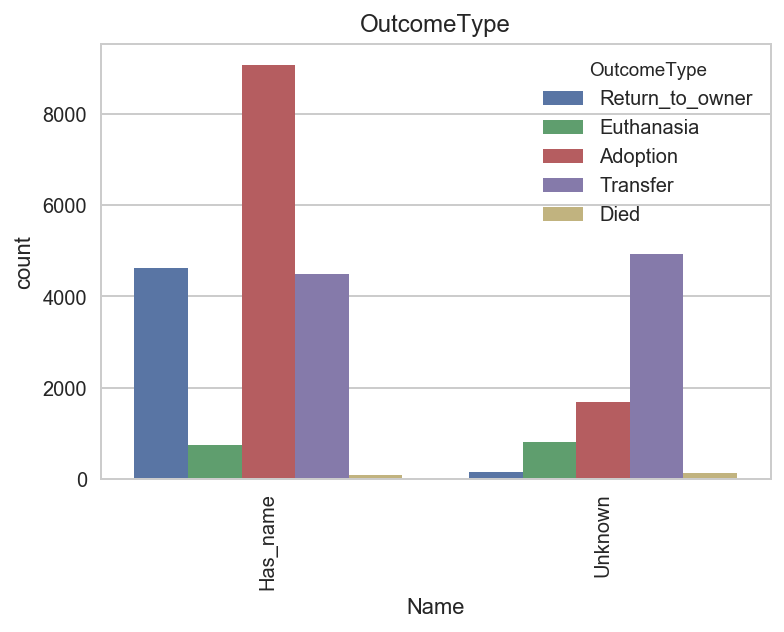

In [158]:
# 이름이 있는 경우 어덥션 높고 이름 없는 경우 transfer 높다.
sns.countplot(x="Name", data=df_train , hue ='OutcomeType')
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show() 

### - AnimalType & OutcomeType

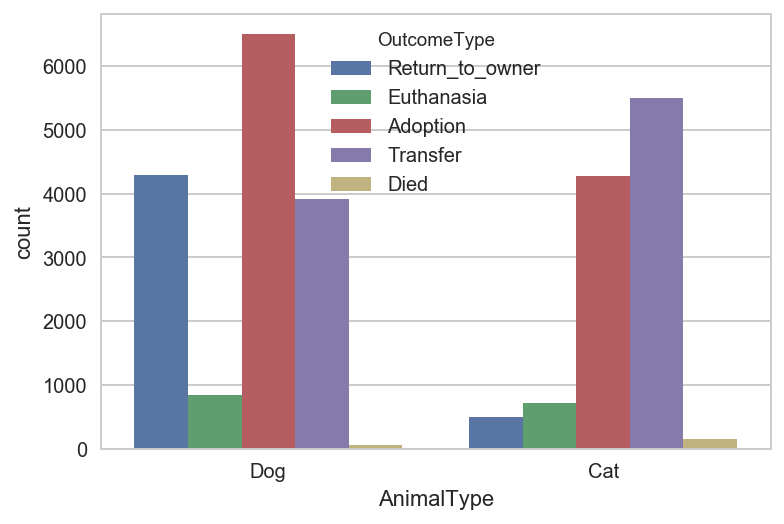

In [159]:
sns.countplot(x='AnimalType',data=df_train, hue='OutcomeType')
plt.show()

### - SexuponOutcome & OutcomeType

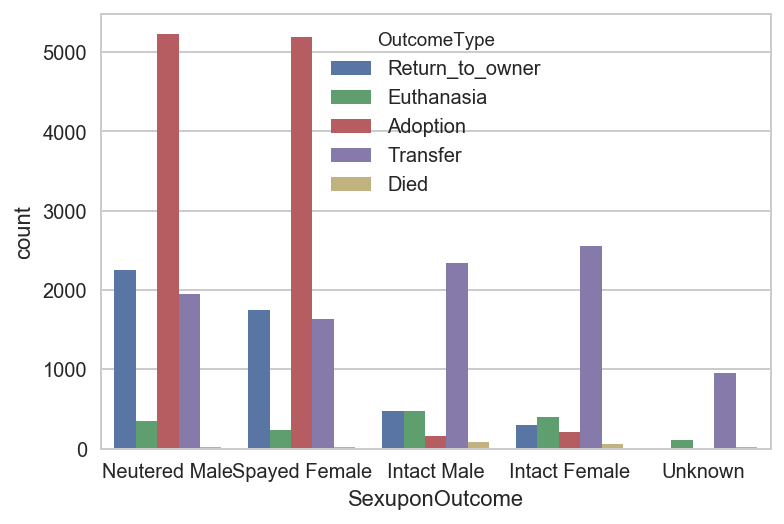

In [160]:
# 중성화 된 동물들의 어덥션이 높고 중성화 되지 않은 동물들이 transfer 된 경우가 많음
sns.countplot(x='SexuponOutcome',data=train, hue='OutcomeType')
plt.show()

### - AgeuponOutcome & OutcomeType

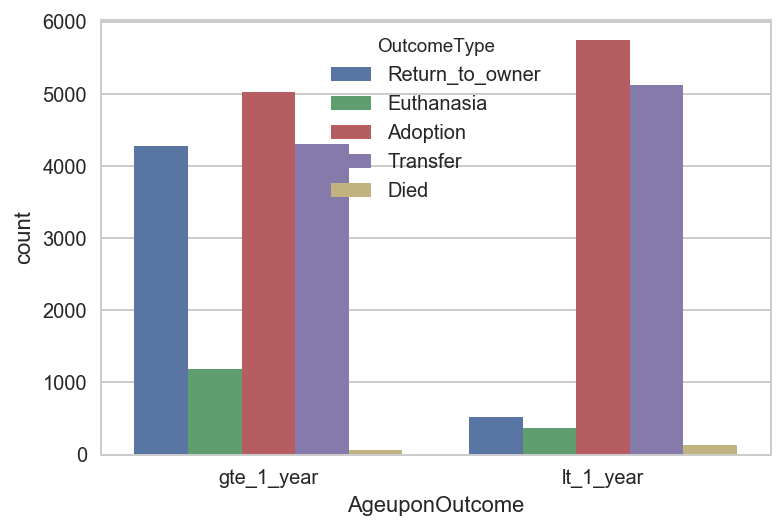

In [163]:
# 1살 이상의 동물들이 주인에게 돌아가는 경우가 많다.
sns.countplot(x='AgeuponOutcome',data=df_train, hue='OutcomeType')
plt.show()

동물의 나이별(년) 개체수 통계


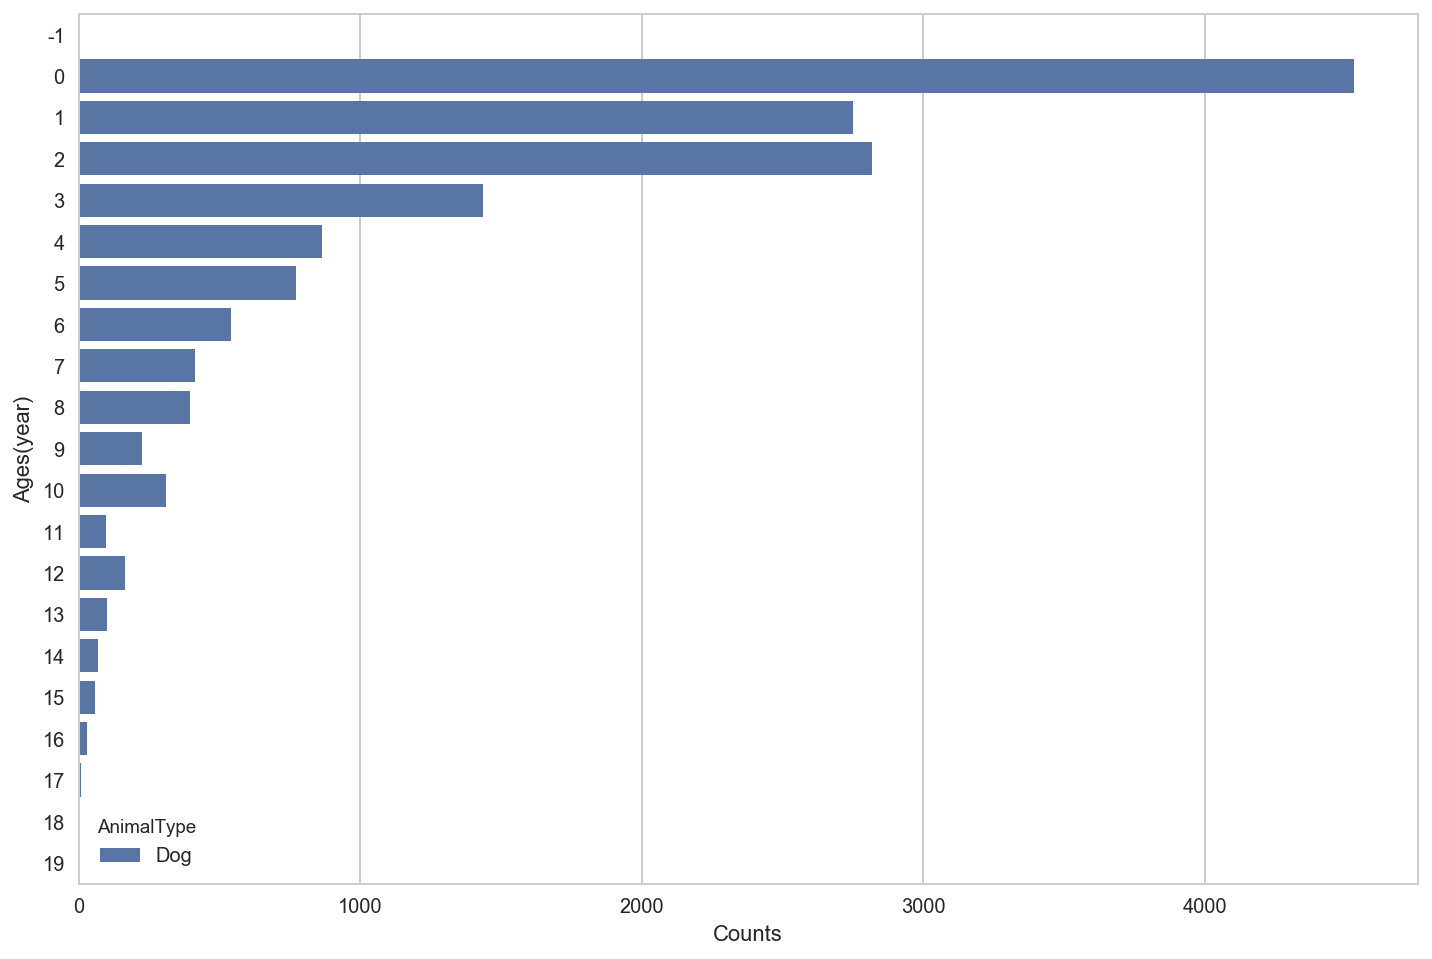

In [470]:
# 위 그래프 정제결과1 : 동
sorted_df = df_train.groupby(["Age_ynbr","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_ynbr", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("동물의 나이별(년) 개체수 통계")

### - Color & OutcomeType

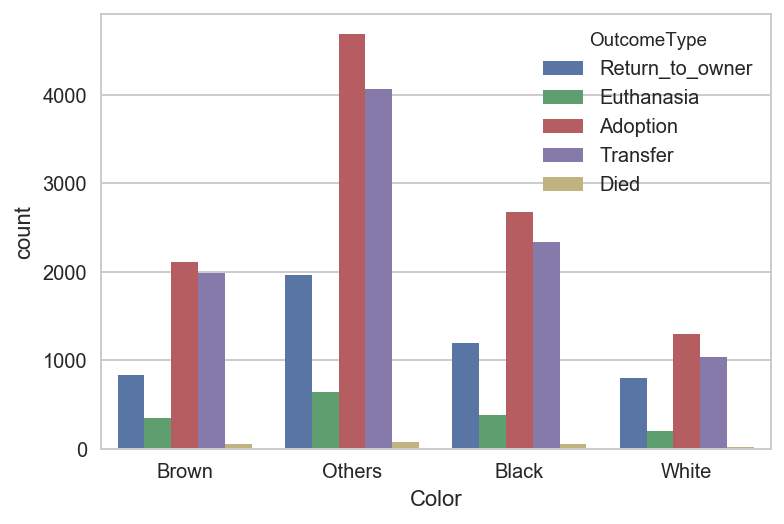

In [67]:
# 색상별로 큰 분포의 차이를 보이진 않아 추후 다른 아이디어를 이용해 볼 예정
sns.countplot(x='Color',data=train, hue='OutcomeType')
plt.show()

동물의 처리결과별 - 특징 통계


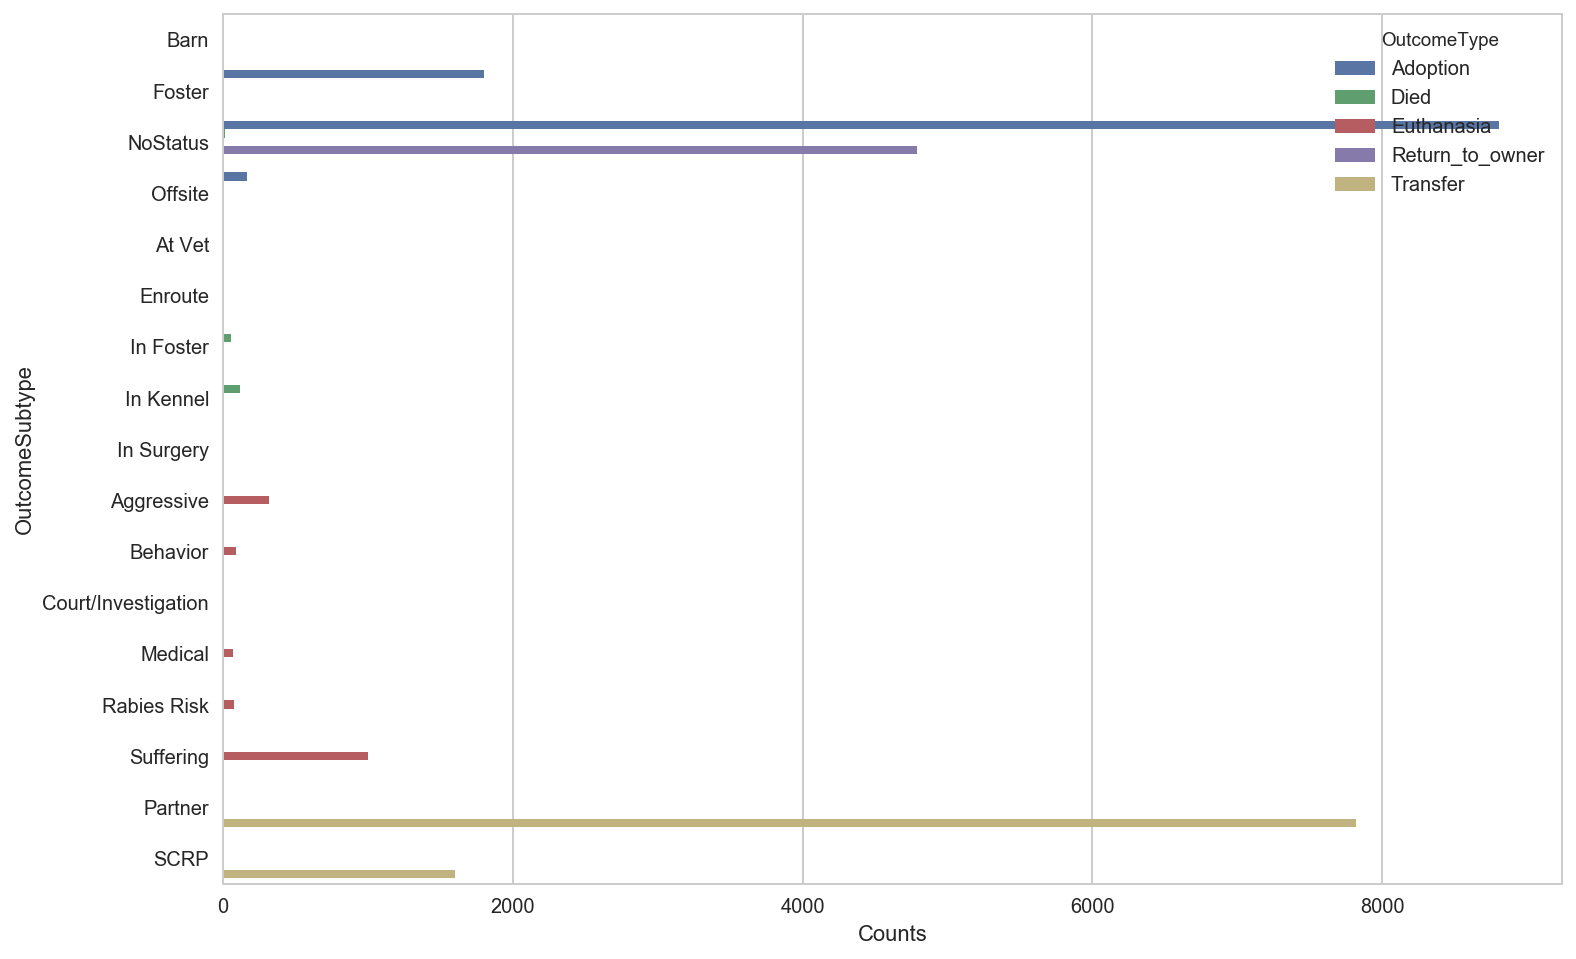

In [16]:
sorted_df = df_train.groupby(["OutcomeType","OutcomeSubtype"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeSubtype", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeSubtype')
print("동물의 처리결과별 - 특징 통계")

### 5-6. Breed

- 개, 고양이의 종류

In [317]:
extra = df_train.groupby('Breed_extra').size().reset_index(name="count").sort_values("count",ascending=False)
extra.head(10)

,Breed_extra,count
0,,10377
396,Chihuahua,2002
939,PitBull,1972
739,LabradorRetriever,1432
604,GermanShepherd,652
1105,Siamese,413
490,Dachshund,405
71,AustralianCattleDog,392
282,Boxer,275
846,MiniaturePoodle,254


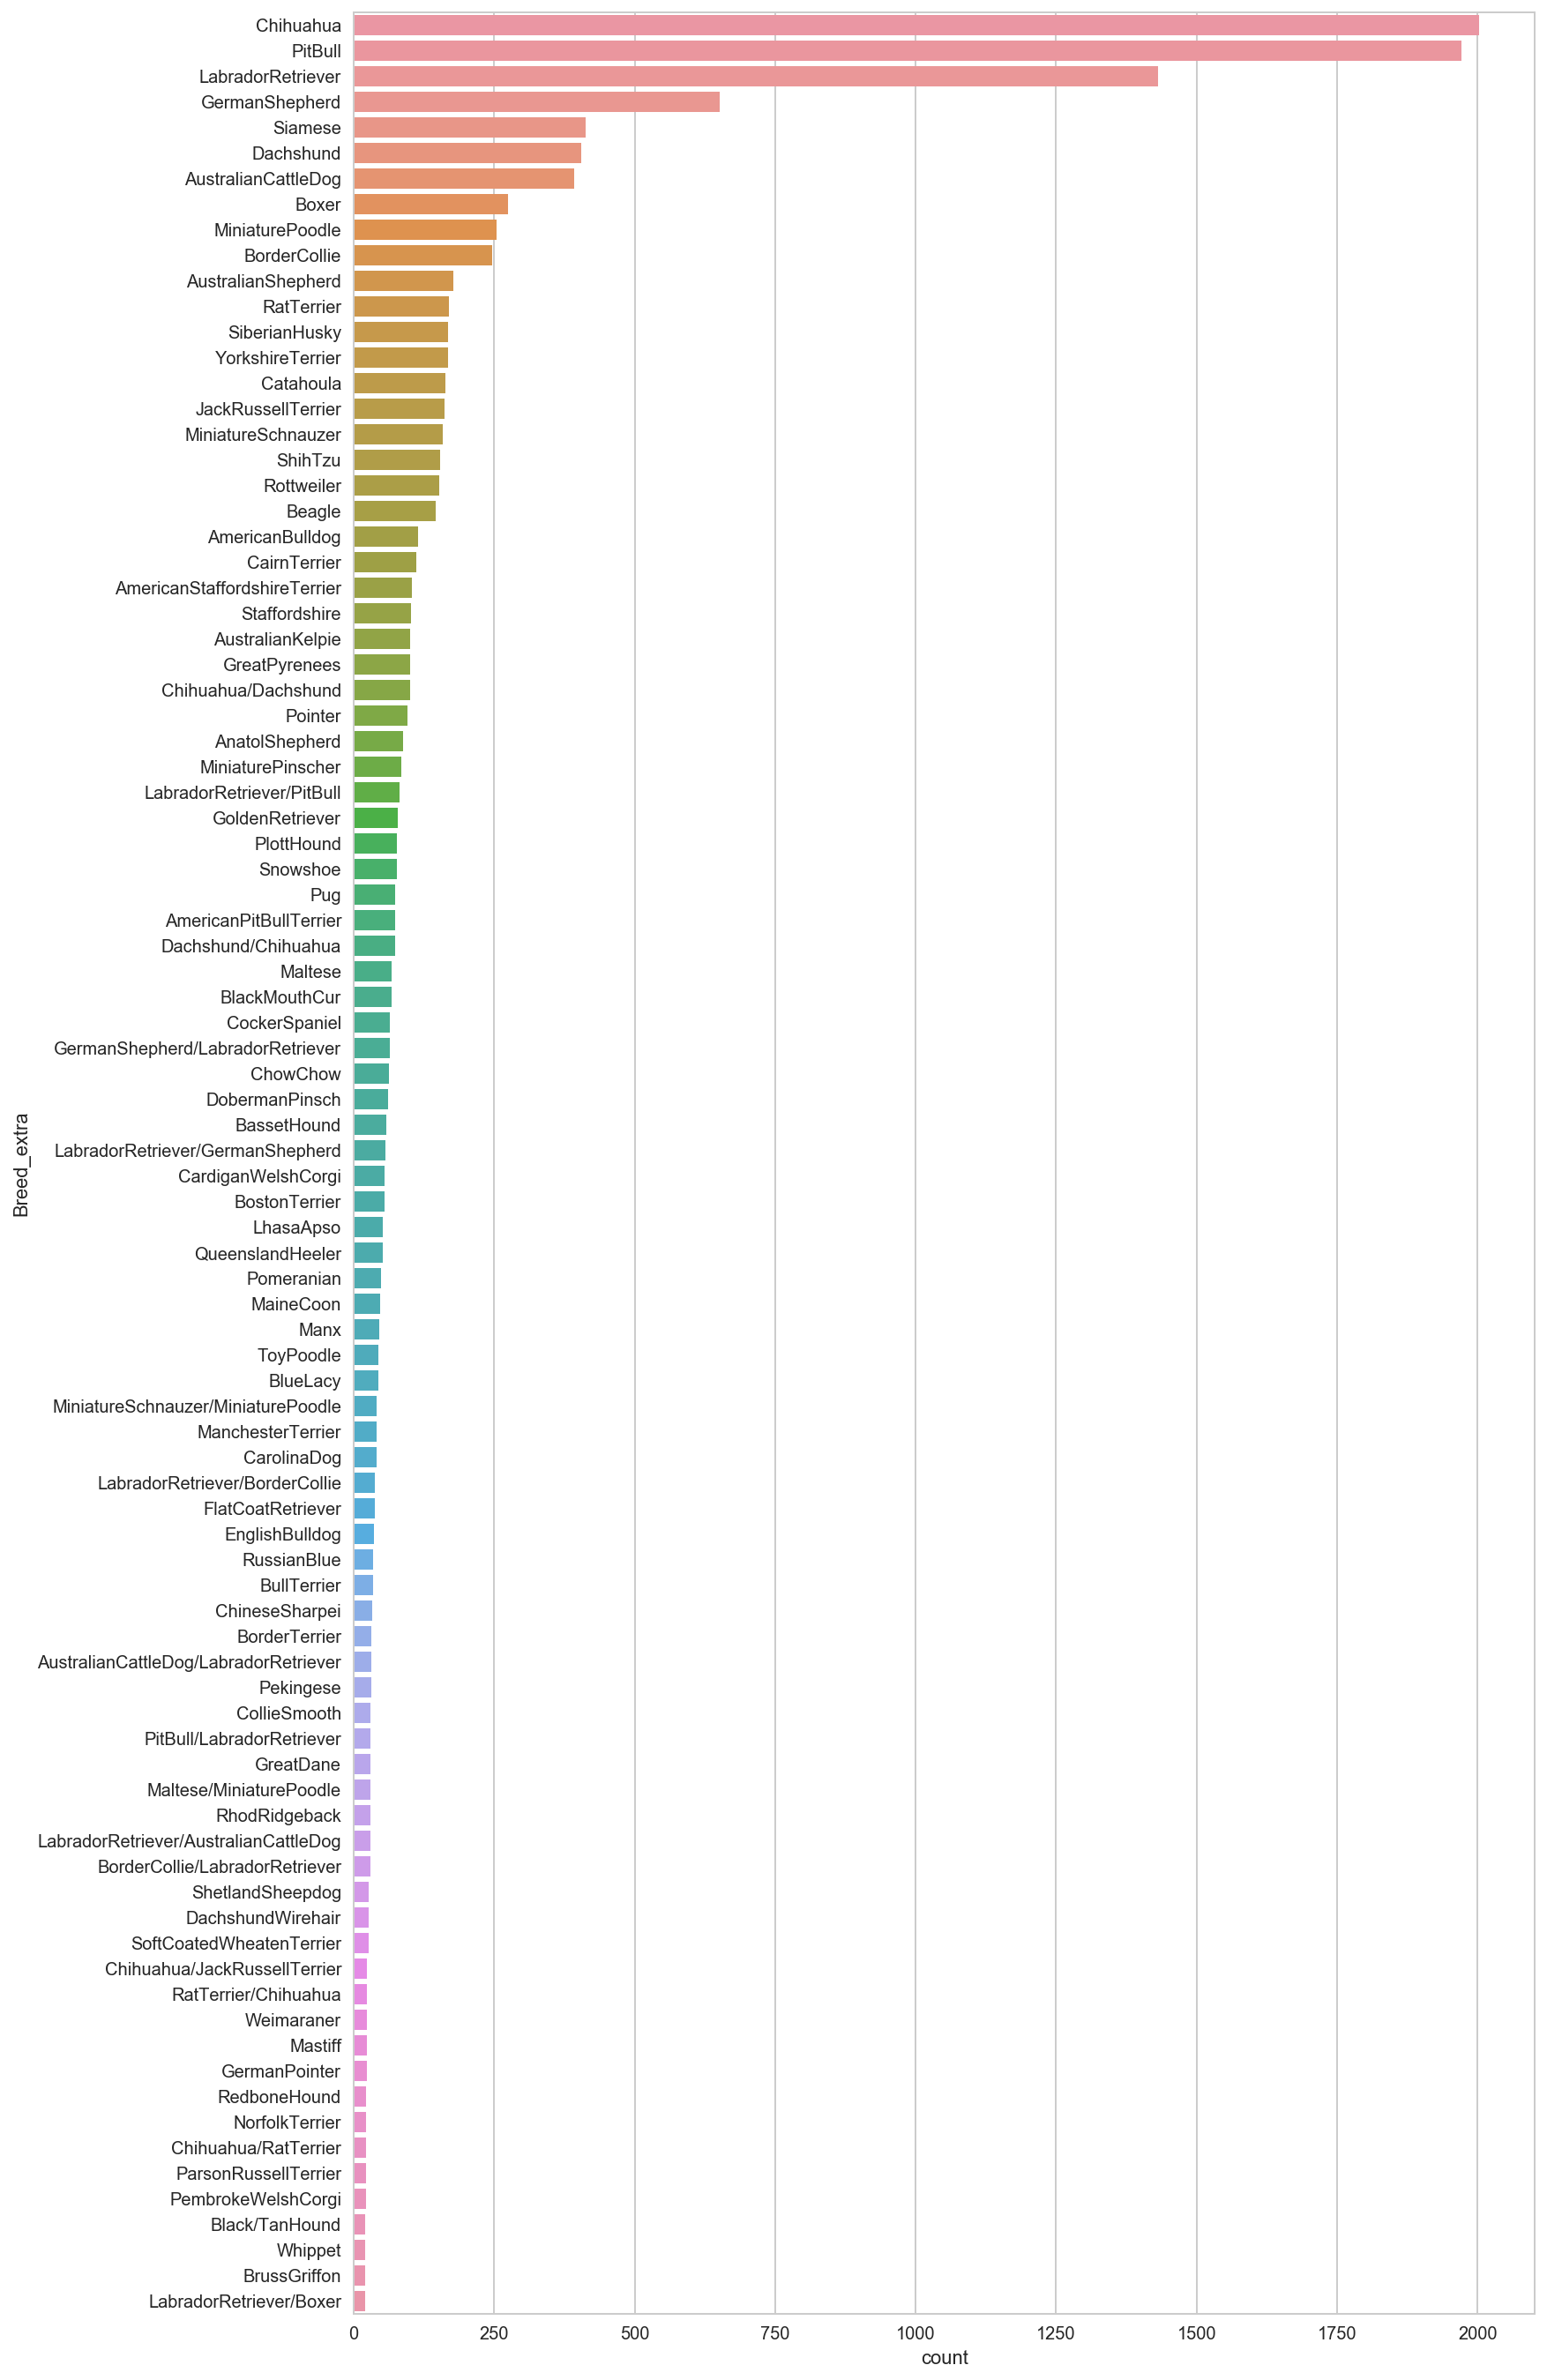

In [320]:
plt.figure(figsize=(12,24))
sns.barplot(x="count",y="Breed_extra",data=extra[(extra["count"]>20)&(extra["count"]<3000)])

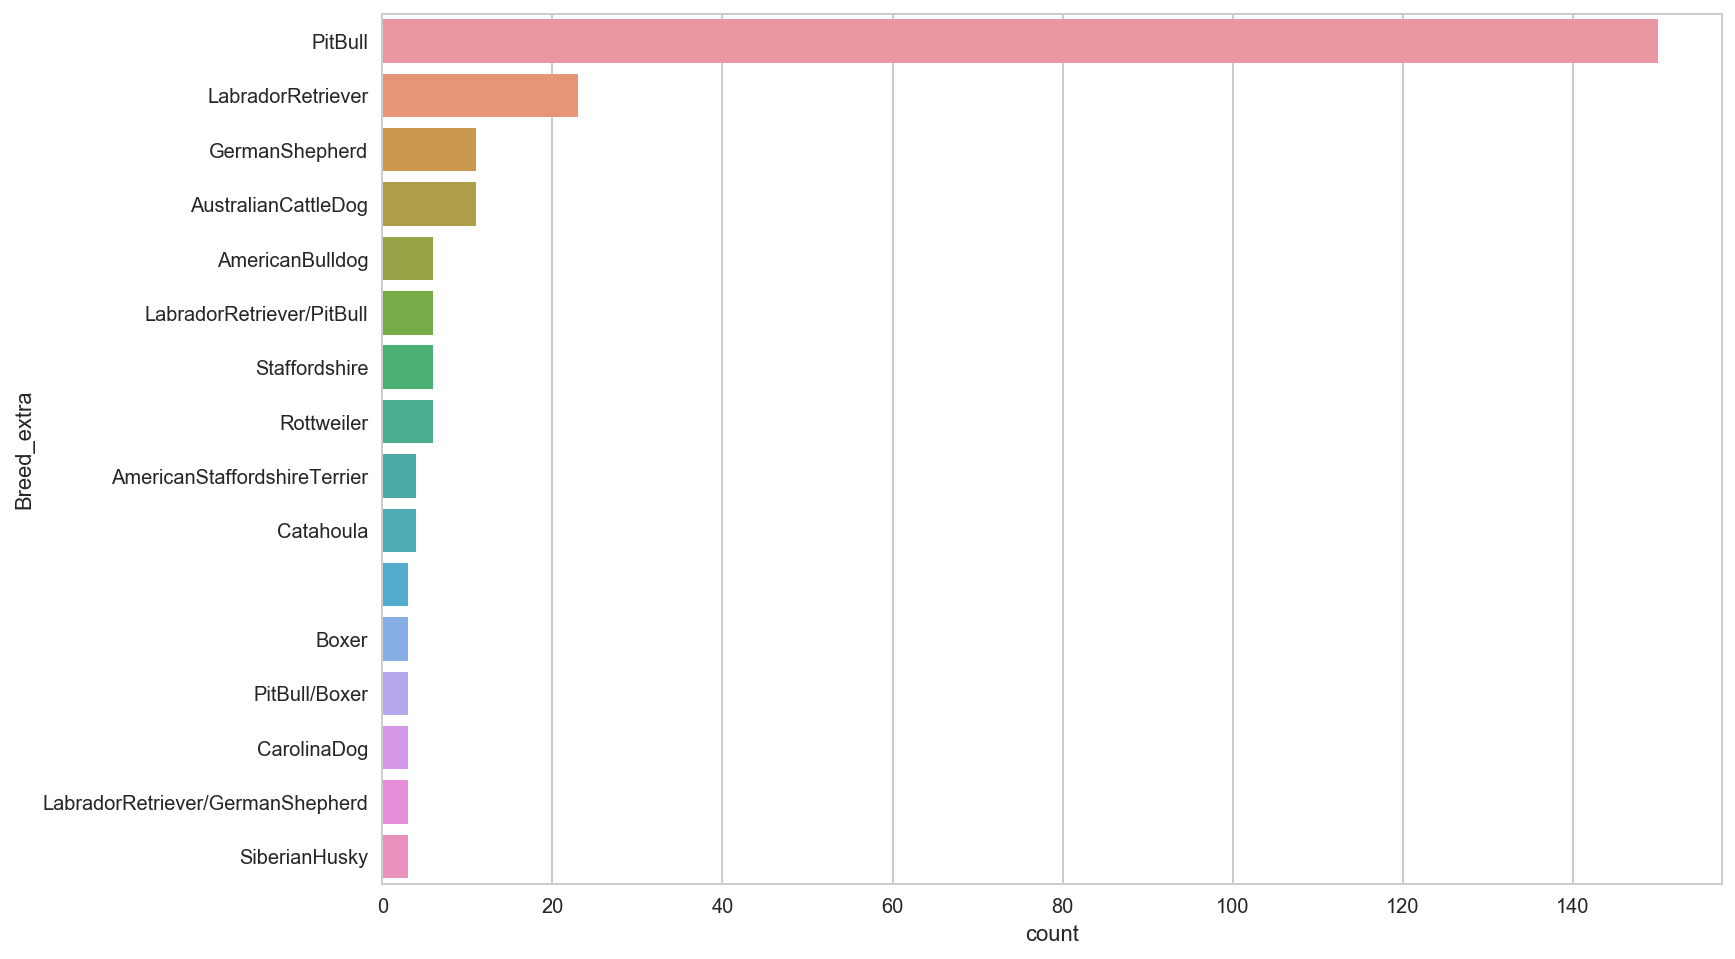

In [321]:
temp = df_train[df_train["OutcomeSubtype"]=="Aggressive"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>2])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

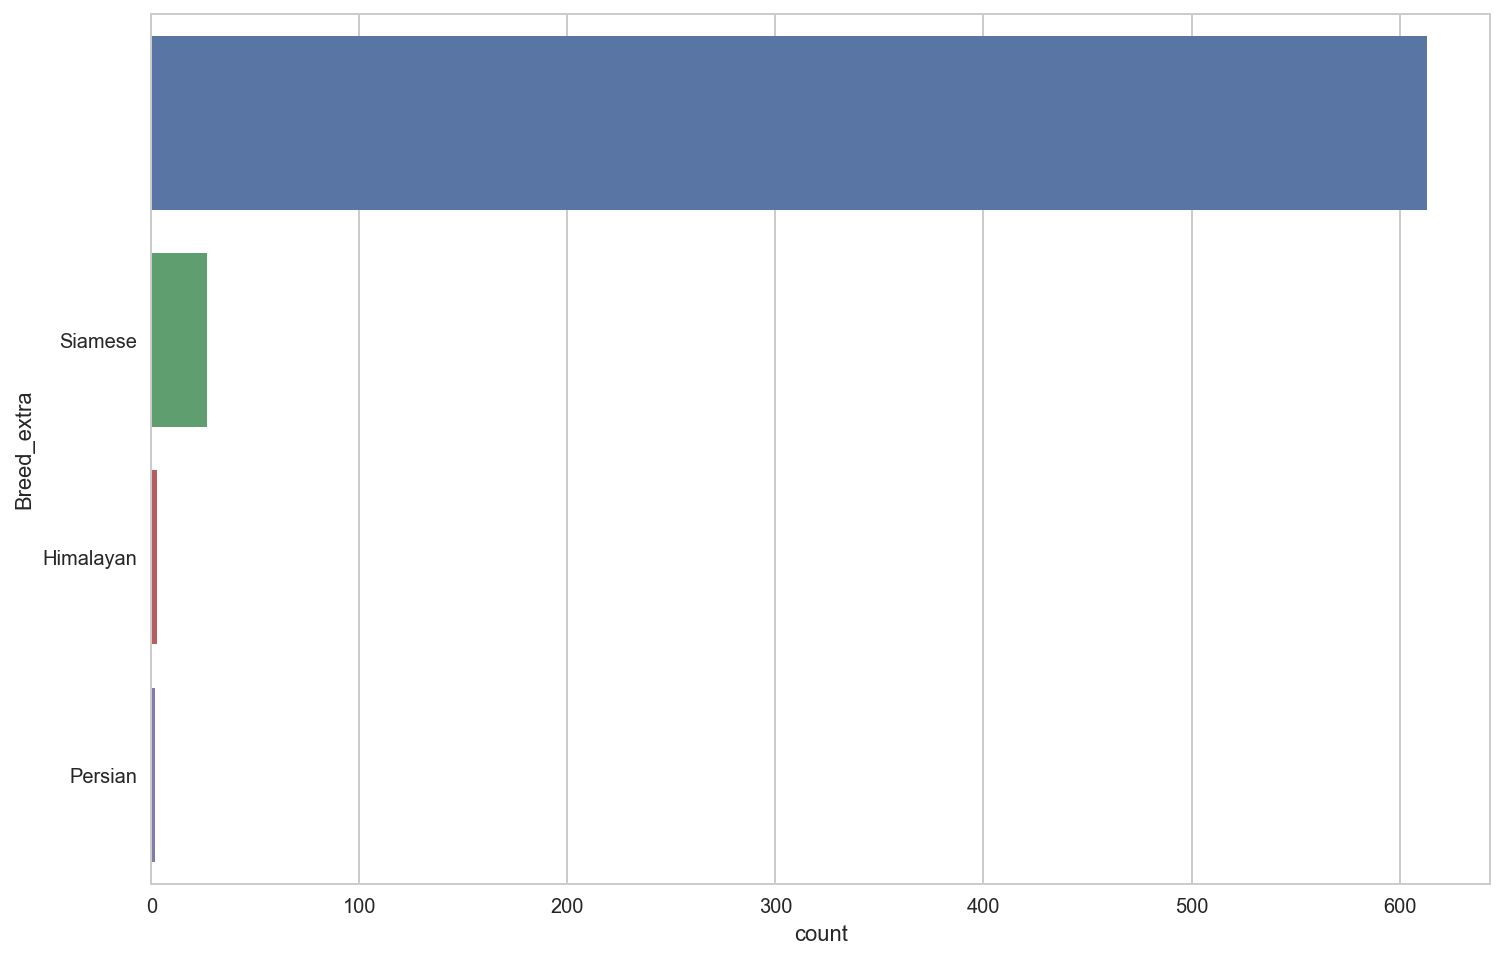

In [30]:
temp = df_train[df_train["OutcomeSubtype"]=="Suffering"]
temp = temp[temp["AnimalType"]=="Cat"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>1])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

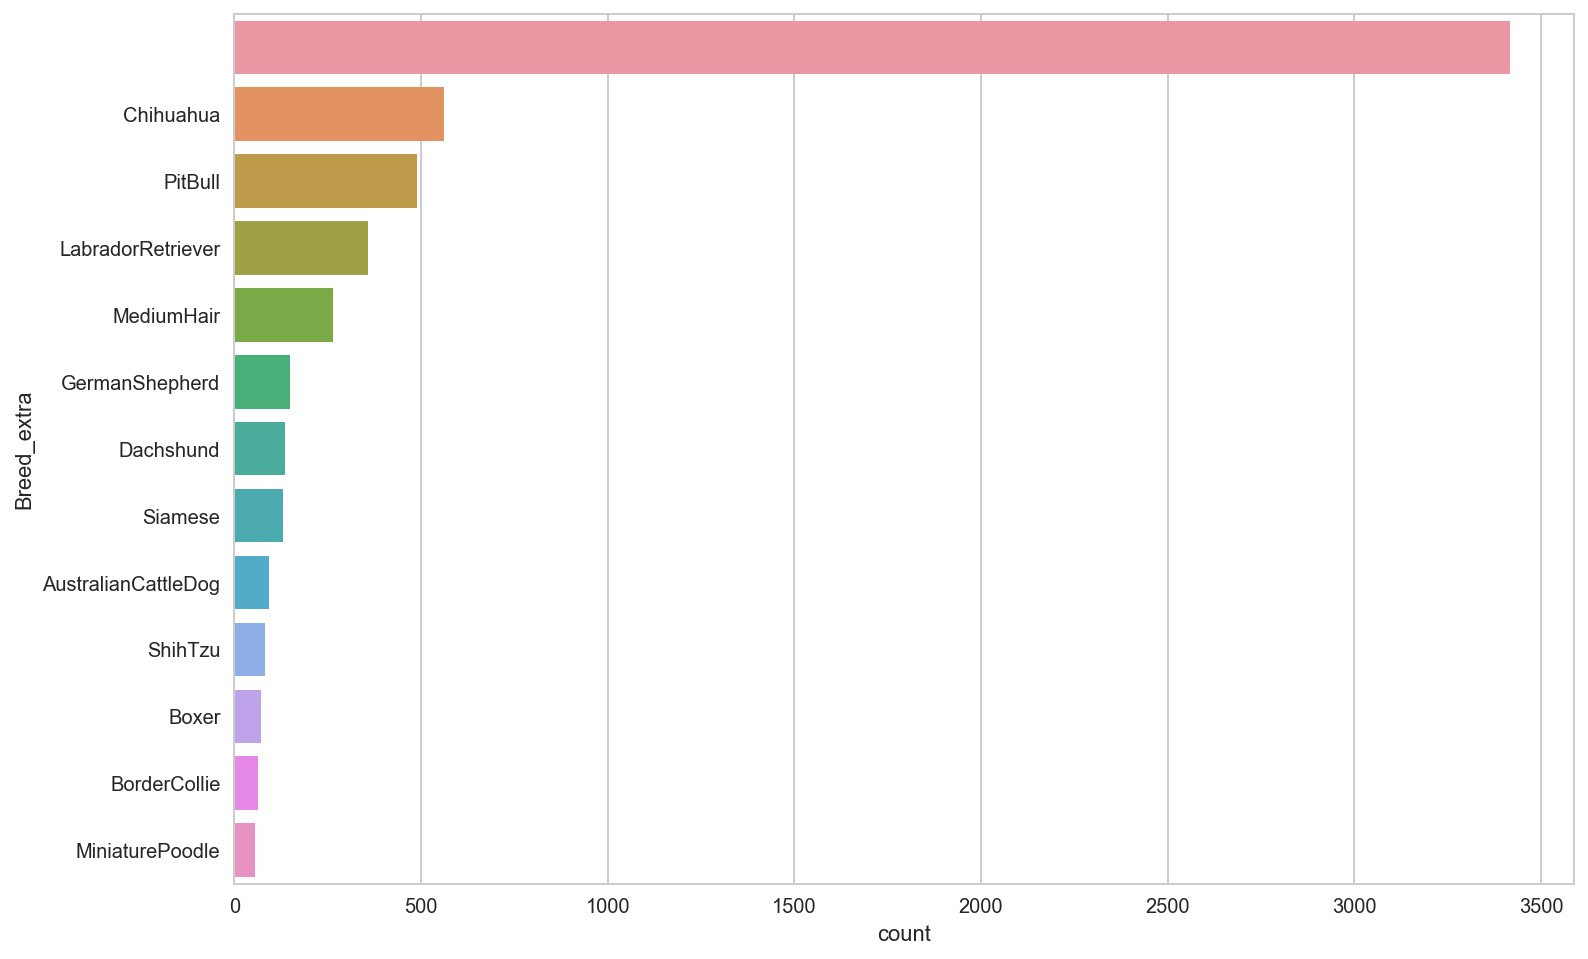

In [17]:
temp = df_train[df_train["OutcomeSubtype"]=="Partner"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>50])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

[]

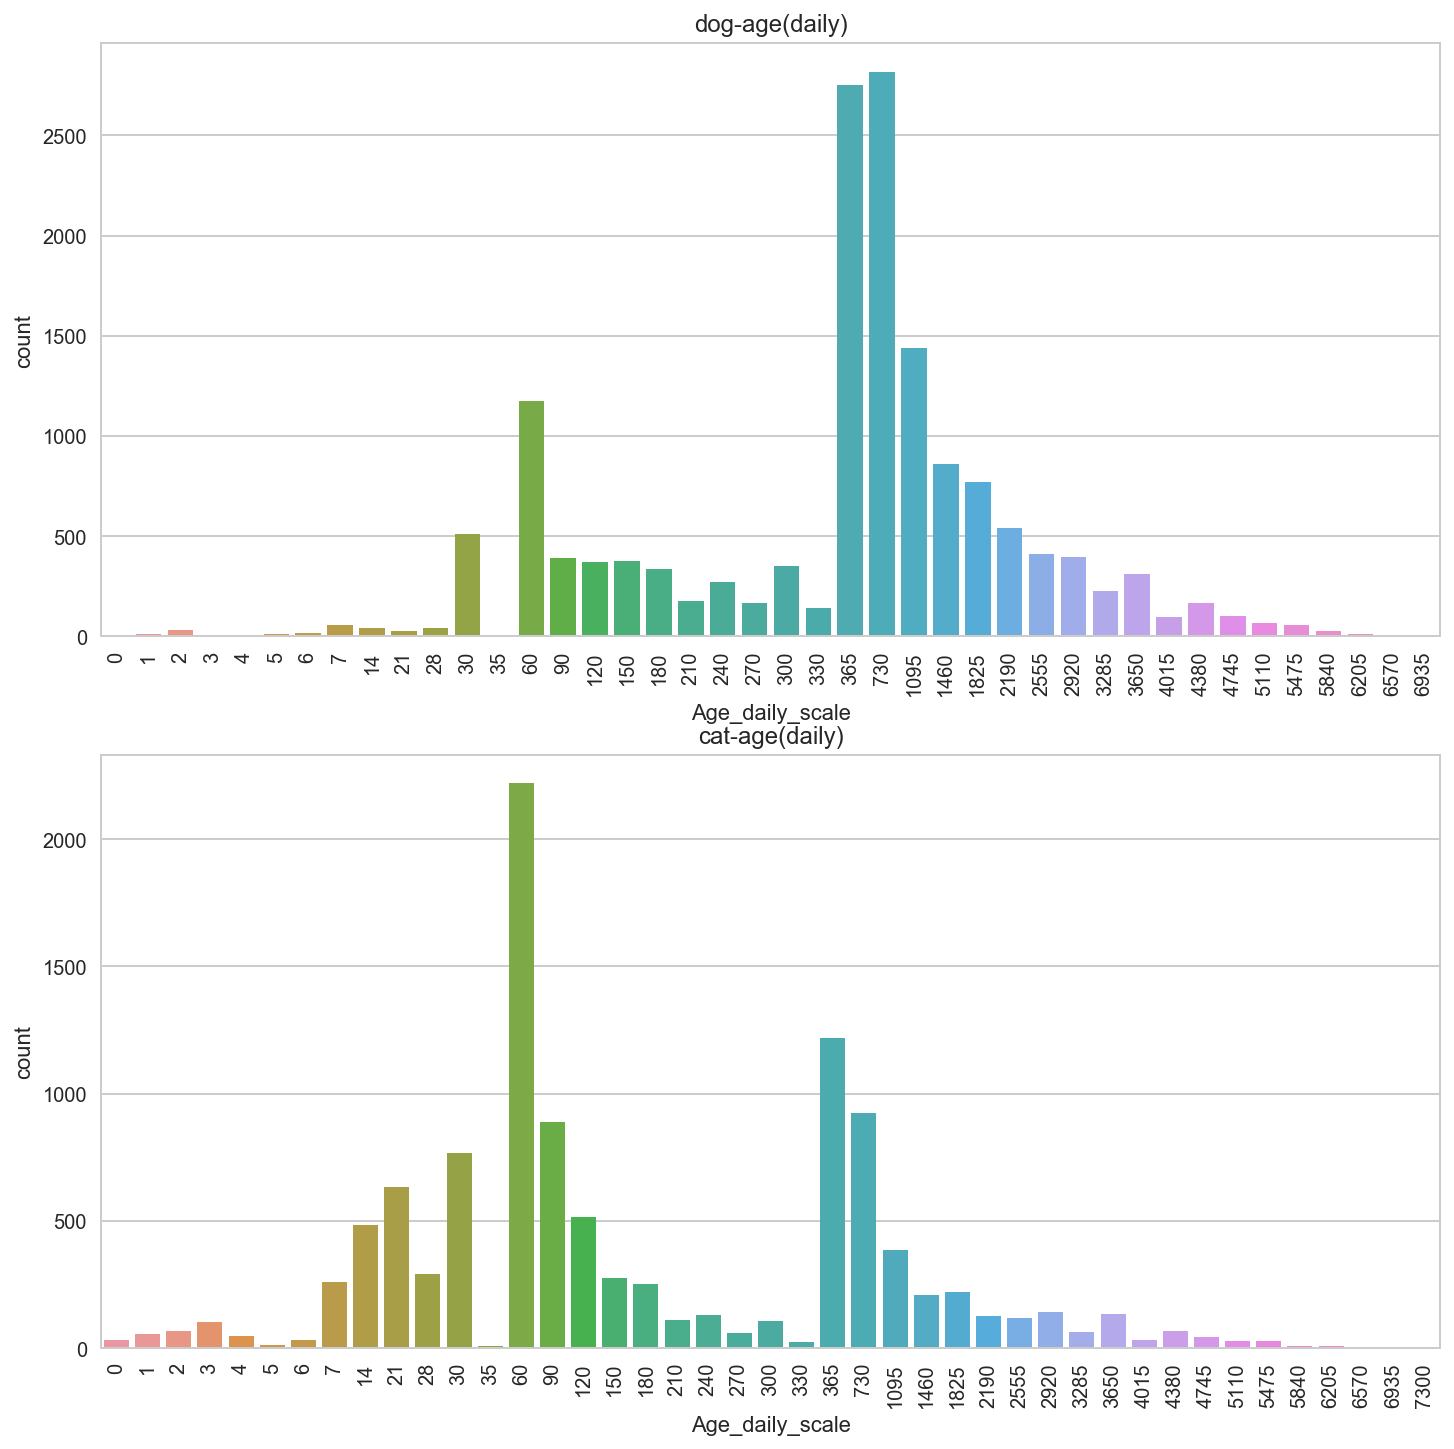

In [82]:
temp1 = df_train[df_train["AnimalType"]=="Dog"]
temp1 = temp1.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

temp2 = df_train[df_train["AnimalType"]=="Cat"]
temp2 = temp2.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

plt.figure(figsize=(12,12))
plt.subplot(211)
sns.barplot(data=temp1, x='Age_daily_scale',y='count').set_title("dog-age(daily)")
plt.xticks(rotation="vertical")
plt.subplot(212)
sns.barplot(data=temp2, x='Age_daily_scale',y='count').set_title("cat-age(daily)")
plt.xticks(rotation="vertical")
plt.plot()

## 6. Classification Modeling - Cross Validation
0. 나이브 베이지안
1. 의사결정나무
2. 랜덤포레스트
3. XGBoost
4. 앙상블 = 랜덤포레스트 + XGBoost
5. 신경망 - keras

### 분석용 변수 설정

In [54]:
#사전조건 설정 (고양이 or 개)
# train_if = train.copy()
train_if = train[train["AnimalType"]=="Cat"].copy()
# train_if = train[train["AnimalType"]=="Dog"].copy()

In [55]:
# y값 카테고리화
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = train_if['OutcomeType']
le.fit(y)
y= le.transform(y)
y

array([2, 4, 4, ..., 4, 4, 4], dtype=int64)

In [56]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [57]:
#분석할 컬럼들
cols1= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']
cols2=['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf',
       'Age_daily_scale', 'Age_code',
       'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM','Breed_extra','Breed_Pitbull',
       'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
       'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']

df_train2 = preprocessShelter(train_if)
df_colors2, df_breeds2 = preprocessColorBreed(df_train2)

# df_OHE = allOneHotEncoder(df_train2,cols2)
df_Ctg = allCategorizer(df_train2,cols2)
# temp.head(20)
# df_train[cols]
df_final = pd.concat([df_Ctg,df_colors2],axis=1)# , df_breeds2
cols_f = len(df_final.columns)

#성능이 좋은 세팅
# 고양이 : 

# 강아지 : 카테고리종 한군데 분류
# cols2=['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf',
#        'Age_daily_scale', 'Age_code',
#        'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM','Breed_extra','Breed_Pitbull',
#        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
#        'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
# df_final = pd.concat([df_Ctg,df_colors2],axis=1)# , df_breeds2
# 결합형

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Categorizing start... using  ['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_daily_scale', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Breed_Pitbull', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , Complete!


In [58]:
df_final.columns

Index(['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_daily_scale', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Breed_Pitbull', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Time_weekend', 'Time_operating', 'Time_season', 'Holidays', 'Color_mix', 'Color_extra', 'Color_ful', 'Color_black', 'Color_white', 'Color_gray', 'Color_gold', 'Color_brown'], dtype='object')

### 의사결정나무 + cv

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
model testing...
Tree Model1: Mean score: 0.733 --- acuraccy score : 0.733
Tree Model2: Mean score: 0.733 --- acuraccy score : 0.733
Tree Model3: Mean score: 0.748 --- acuraccy score : 0.748
Tree Model4: Mean score: 0.763 --- acuraccy score : 0.764
Tree Model5: Mean score: 0.787 --- acuraccy score : 0.789
Tree Model6: Mean score: 0.787 --- acuraccy score : 0.794
Tree Model7: Mean score: 0.787 --- acuraccy score : 0.802
Tree Model8: Mean score: 0.786 --- acuraccy score : 0.812
Tree Model9: Mean score: 0.783 --- acuraccy score : 0.826
Tree Model10: Mean score: 0.783 --- acuraccy score : 0.842
Tree Model11: Mean score: 0.782 --- acuraccy score : 0.863
Tree Model12: Mean score: 0.774 --- acuraccy score : 0.885
Tree Model13: Mean score: 0.767 --- acuraccy score : 0.911
Tree Model14: Mean score: 0.766 --- acuraccy score : 0.933
Tree Model15: Mean score: 0.758 --- acuraccy score : 0.950


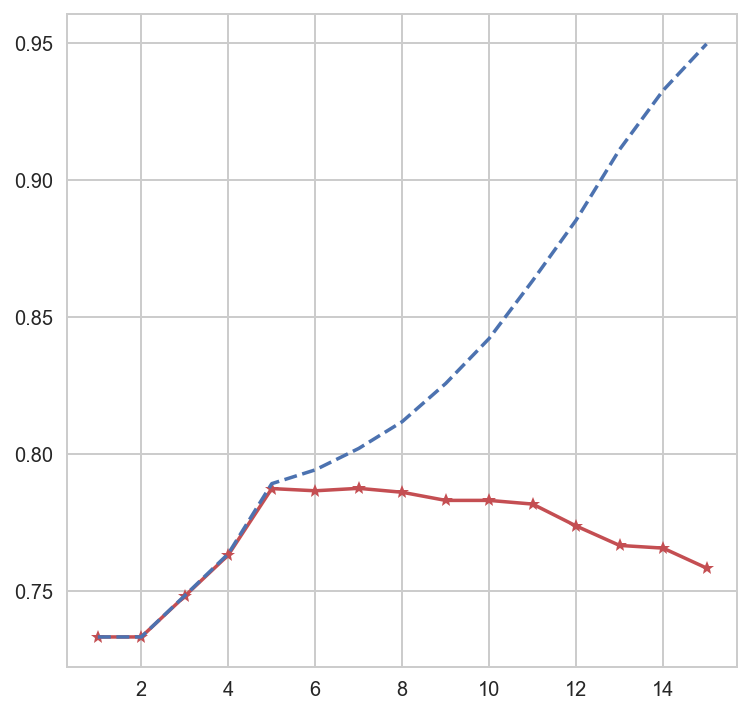

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
tree_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,16):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    tree_ls.append(tree)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(tree_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("Tree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
# 고양이 : 0.787 - depth : 5
# 강아지 : 0.583 - depth : 9
# 결합모형 : 

In [60]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
treeA = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0).fit(df_final,y)

from sklearn.metrics import *
print("- Accuracy_Score : ", accuracy_score(y,treeA.predict(df_final)))
print("- Confusion_Matrix \n",confusion_matrix(y, treeA.predict(df_final)))
print(classification_report(y, treeA.predict(df_final), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,treeA.predict(df_final)))

- Accuracy_Score :  0.789204239267
- Confusion_Matrix 
 [[3704    0    2    0  566]
 [   8    7    5    0  127]
 [  43    0  124    0  543]
 [ 236    0    3    0  261]
 [ 518    0   35    0 4952]]
                 precision    recall  f1-score   support

       Adoption       0.82      0.87      0.84      4272
           Died       1.00      0.05      0.09       147
     Euthanasia       0.73      0.17      0.28       710
Return_to_owner       0.00      0.00      0.00       500
       Transfer       0.77      0.90      0.83      5505

    avg / total       0.75      0.79      0.75     11134



C:\Users\creal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


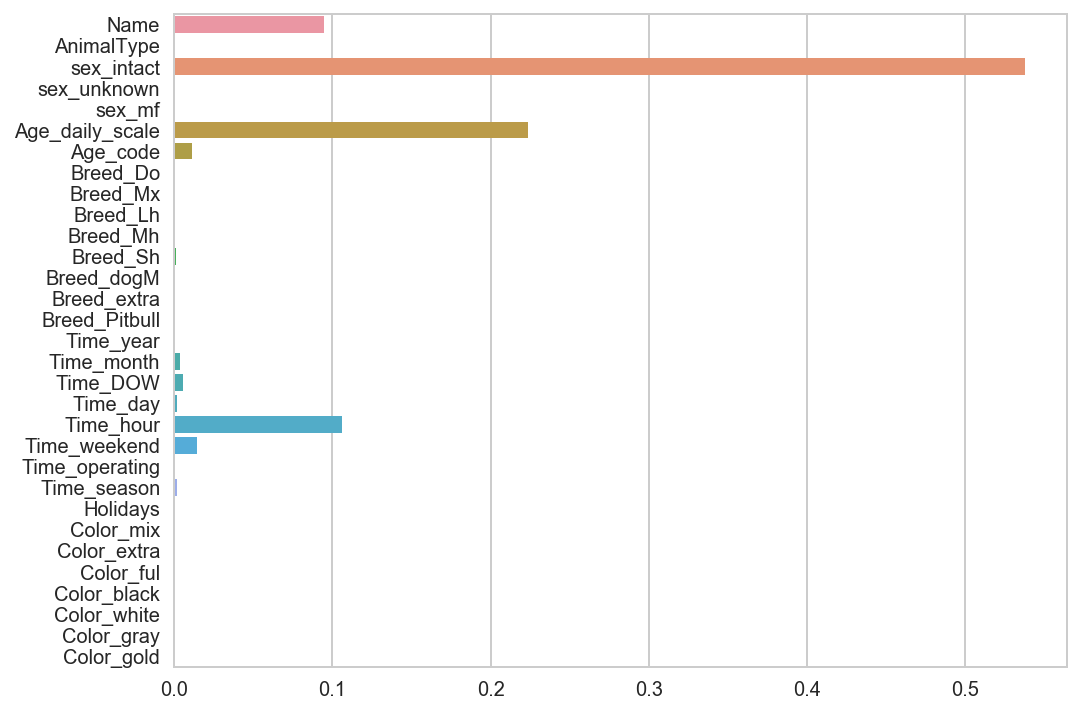

In [61]:
###### 피쳐 중요도
importance = treeA.feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### 랜덤포레스트 + cv

RFmodel creating.., 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
model testing...
RandomForest Model1: Mean score: 0.749 --- acuraccy score : 0.749
RandomForest Model2: Mean score: 0.761 --- acuraccy score : 0.765
RandomForest Model3: Mean score: 0.776 --- acuraccy score : 0.782
RandomForest Model4: Mean score: 0.784 --- acuraccy score : 0.799
RandomForest Model5: Mean score: 0.786 --- acuraccy score : 0.805
RandomForest Model6: Mean score: 0.788 --- acuraccy score : 0.822
RandomForest Model7: Mean score: 0.791 --- acuraccy score : 0.840
RandomForest Model8: Mean score: 0.796 --- acuraccy score : 0.862
RandomForest Model9: Mean score: 0.798 --- acuraccy score : 0.890
RandomForest Model10: Mean score: 0.800 --- acuraccy score : 0.916
RandomForest Model11: Mean score: 0.803 --- acuraccy score : 0.940
RandomForest Model12: Mean score: 0.804 --- acuraccy score : 0.963
RandomForest Model13: Mean score: 0.806 --- acuraccy score : 0.981
RandomForest Model14: Mean score: 0.805 --- acu

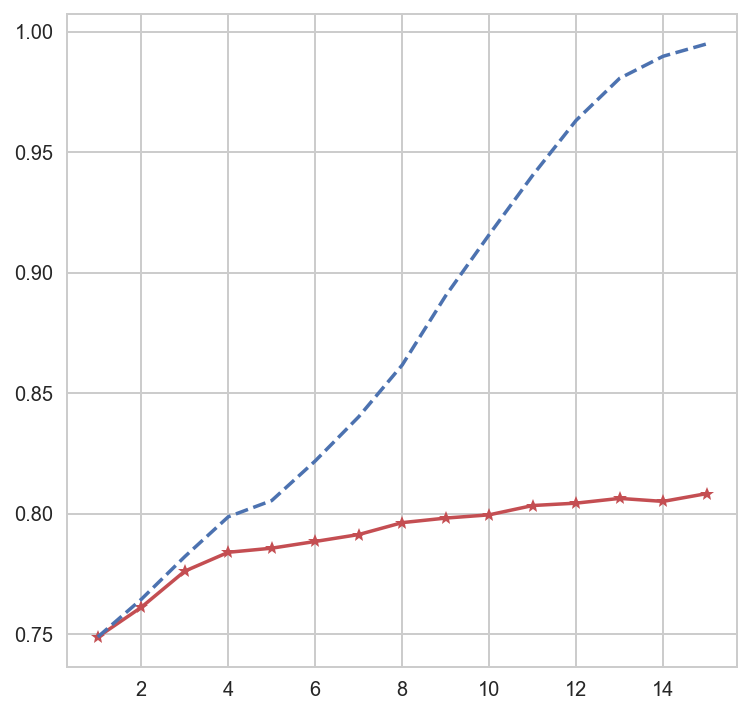

EXmodel creating.., 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
model testing...
ExtraTree Model1: Mean score: 0.720 --- acuraccy score : 0.718
ExtraTree Model2: Mean score: 0.743 --- acuraccy score : 0.743
ExtraTree Model3: Mean score: 0.742 --- acuraccy score : 0.746
ExtraTree Model4: Mean score: 0.755 --- acuraccy score : 0.770
ExtraTree Model5: Mean score: 0.760 --- acuraccy score : 0.780
ExtraTree Model6: Mean score: 0.763 --- acuraccy score : 0.803
ExtraTree Model7: Mean score: 0.773 --- acuraccy score : 0.816
ExtraTree Model8: Mean score: 0.775 --- acuraccy score : 0.840
ExtraTree Model9: Mean score: 0.780 --- acuraccy score : 0.866
ExtraTree Model10: Mean score: 0.780 --- acuraccy score : 0.890
ExtraTree Model11: Mean score: 0.784 --- acuraccy score : 0.914
ExtraTree Model12: Mean score: 0.783 --- acuraccy score : 0.939


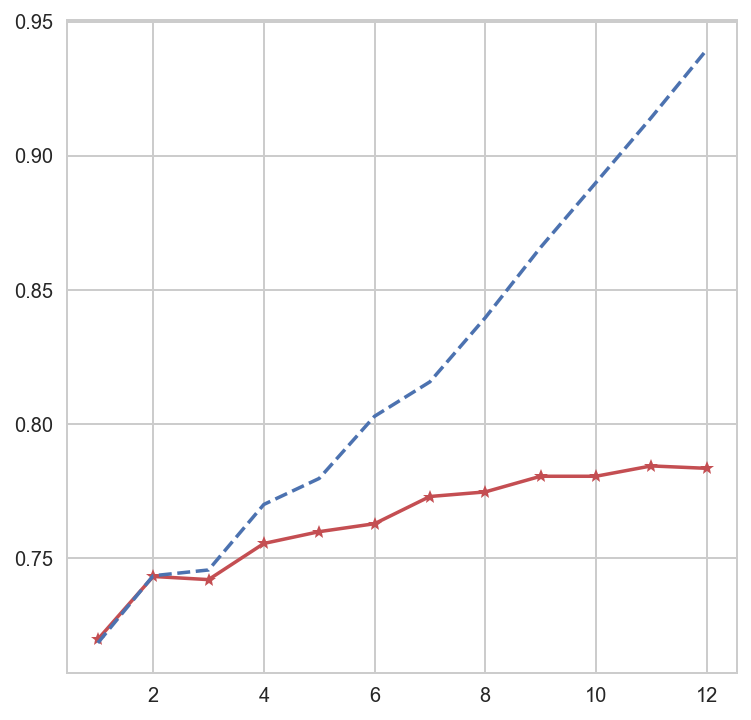

In [62]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
RF_ls = []
score_ls = []
accur_ls = []

# randomforest 모델 자동생성 반복문
print("RFmodel creating..",end="")
for i in range(5,20):
    RF = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    RF_ls.append(RF)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(RF_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("RandomForest Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#----------------------------------------------------------------------
Ex_ls = []
score_ls = []
accur_ls = []
print("EXmodel creating..",end="")
for i in range(5,17):
    Ex = ExtraTreesClassifier(n_estimators=15, criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    Ex_ls.append(Ex)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(Ex_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("ExtraTree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#고양이 cv최고기록 : 0.809 - n-esti:100// depth:20//
#강아지 cv최고기록 : 0.607 - n-esti:100// depth:14//
#종합 cv최고기록 : 0. - n-esti:500// depth:-1// obj:'multi:softprob'// lr=0.5

In [70]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
RF = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_depth=21, random_state=0).fit(df_final,y)

from sklearn.metrics import *
score = cross_val_score(RF, df_final, y,cv=10)
print("- CV_Score : {1:.3f}".format(i+1,np.mean(score)))
print("- Accuracy_Score : ", accuracy_score(y,RF.predict(df_final)))
print("- Confusion_Matrix \n",confusion_matrix(y, RF.predict(df_final)))
print(classification_report(y, RF.predict(df_final), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,RF.predict(df_final)))

- CV_Score : 0.808
- Accuracy_Score :  0.998742590264
- Confusion_Matrix 
 [[4268    0    0    0    4]
 [   0  146    0    0    1]
 [   0    0  707    0    3]
 [   1    0    0  499    0]
 [   5    0    0    0 5500]]
                 precision    recall  f1-score   support

       Adoption       1.00      1.00      1.00      4272
           Died       1.00      0.99      1.00       147
     Euthanasia       1.00      1.00      1.00       710
Return_to_owner       1.00      1.00      1.00       500
       Transfer       1.00      1.00      1.00      5505

    avg / total       1.00      1.00      1.00     11134



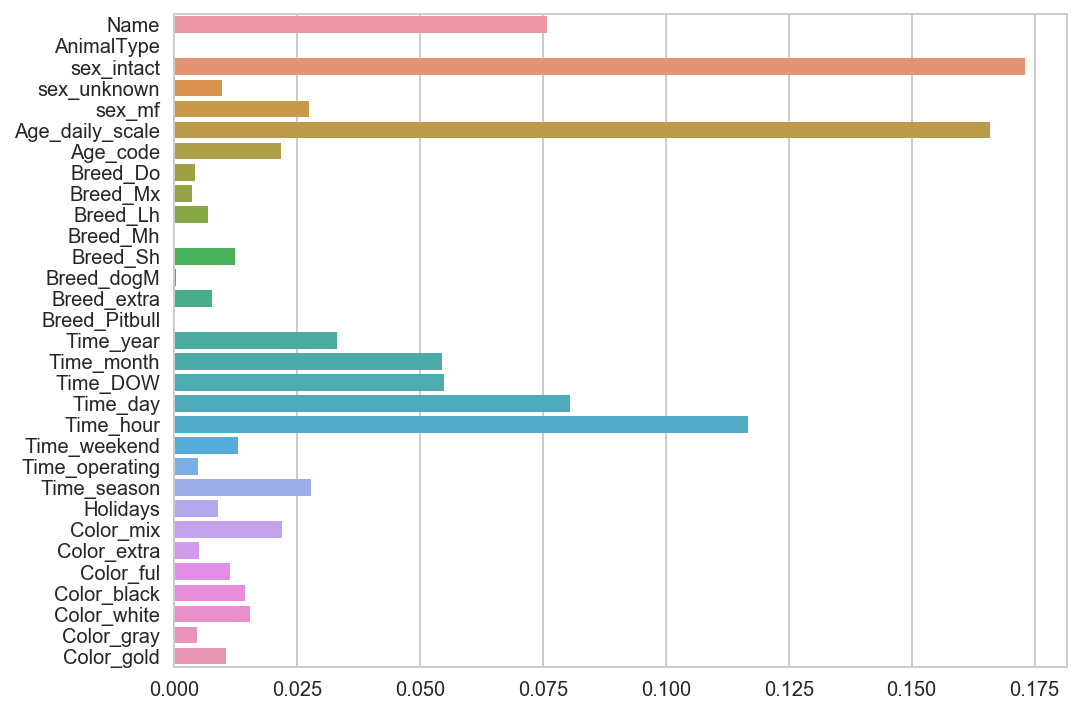

In [69]:
# 피쳐 중요도
importance = RF.feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### XGBoost + cv (느려서 중단)

In [256]:
import xgboost

model creating.., 5, 7, 9, 11, 13, 15
model testing...
XGB Model1: Mean score: 0.689 --- acuraccy score : 0.711
XGB Model2: Mean score: 0.694 --- acuraccy score : 0.743
XGB Model3: Mean score: 0.697 --- acuraccy score : 0.792
XGB Model4: Mean score: 0.699 --- acuraccy score : 0.852
XGB Model5: Mean score: 0.700 --- acuraccy score : 0.902
XGB Model6: Mean score: 0.699 --- acuraccy score : 0.945


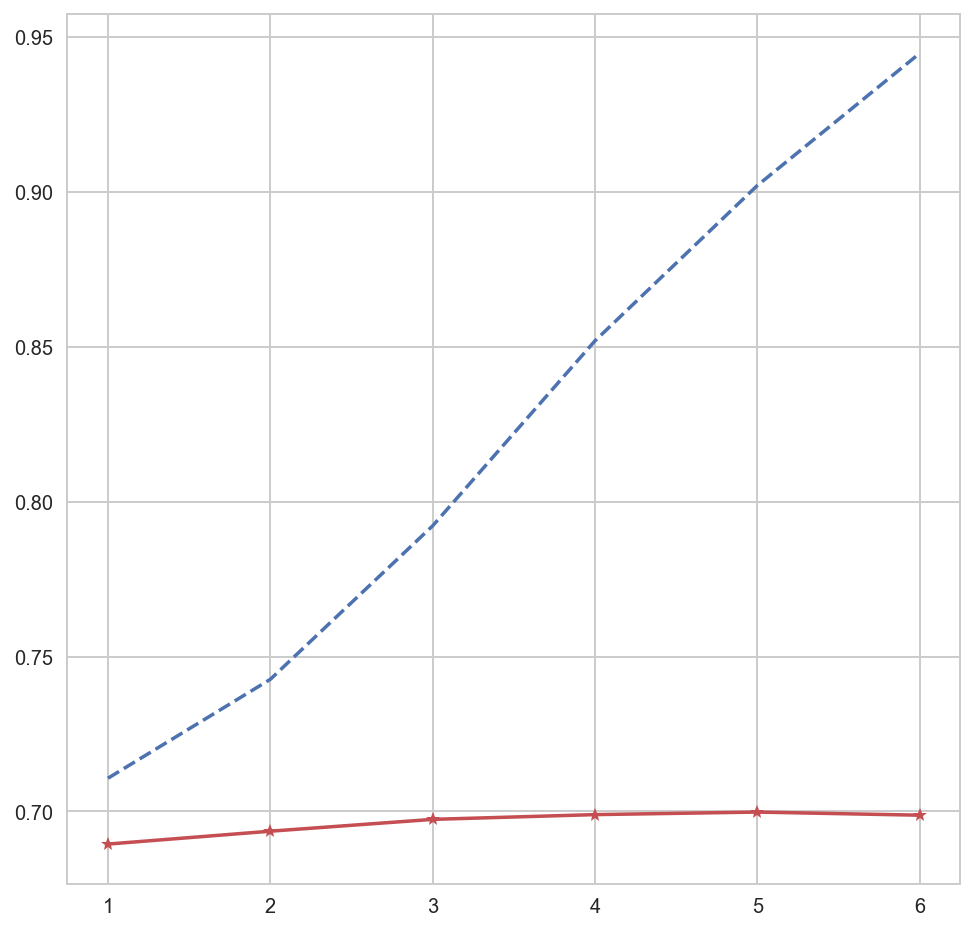

In [242]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost
model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(5,16,2):
    XGB = xgboost.XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    model_ls.append(XGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [243]:
from sklearn.metrics import *

XGB_model = xgboost.XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=14, random_state=0).fit(df_final,y)

scores = cross_val_score(XGB_model, df_final, y,cv=10)
y_pred = XGB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, XGB_model.predict(df_final)))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
print("- Log-loss :", log_loss(y,y_pred))

XGB Model6: Mean score: 0.699 --- acuraccy score : 0.926
- Confusion_Matrix 
 [[10268     0     2   331   168]
 [    8   181     0     5     3]
 [   26     0  1447    38    44]
 [  510     0     0  4165   111]
 [  357     0     2   375  8688]]
                 precision    recall  f1-score   support

       Adoption       0.92      0.95      0.94     10769
           Died       1.00      0.92      0.96       197
     Euthanasia       1.00      0.93      0.96      1555
Return_to_owner       0.85      0.87      0.86      4786
       Transfer       0.96      0.92      0.94      9422

    avg / total       0.93      0.93      0.93     26729



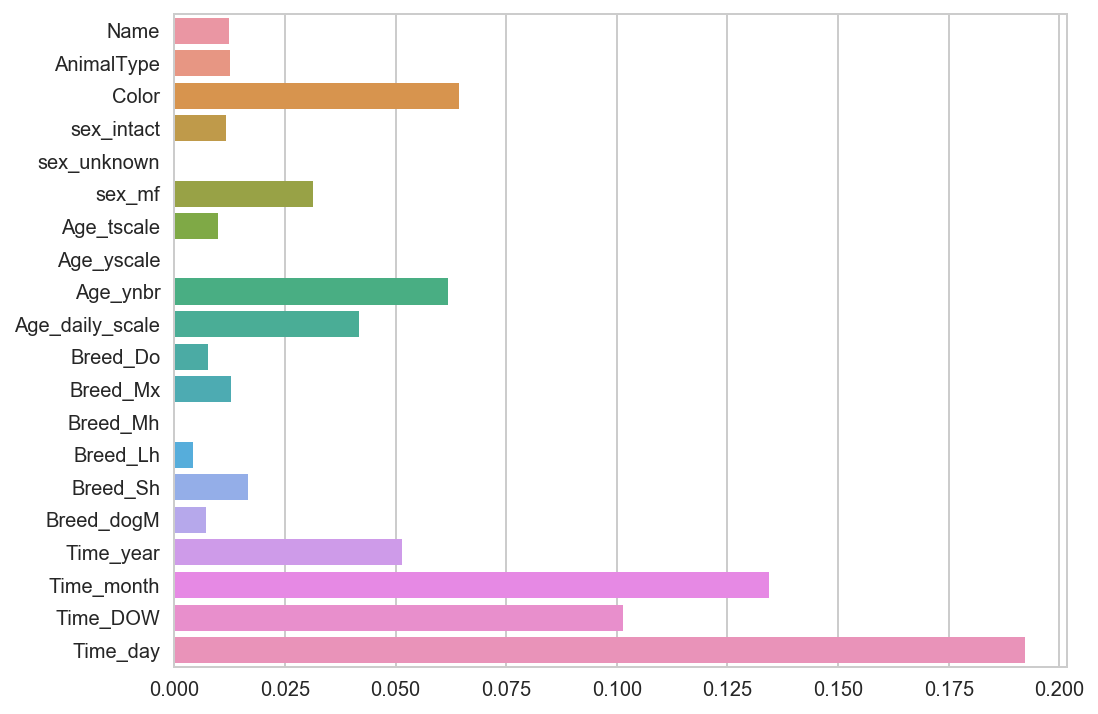

In [245]:
# 피쳐 중요도
importance = XGB_model.feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:20], x=importance[:20])
# importance

In [ ]:
#Dmatrix
from sklearn.model_selection import cross_val_score, KFold
import xgboost
model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,10):
    XGB_Dm = xgboost.DMatrix(df_Ctg.values,).fit(df_Ctg,y)
    print(",",i,end="")
    model_ls.append(XGB_Dm)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_Ctg, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_Ctg))
    print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

### LightGBM 모델 + cv

In [73]:
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(7,22,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_final,y)
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250// depth:12// obj:'multi:softprob'// lr=x
#강아지 cv최고기록 : 0.618 - n-esti:200// depth:-1// obj:'multi:softprob'// lr=x
#종합 cv최고기록 : 0.700 - n-esti:500// depth:-1// obj:'multi:softprob'// lr=0.5

model creating.., 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21
model testing...
LGB Model1: Mean score: 0.816 --- acuraccy score : 0.935
LGB Model2: Mean score: 0.818 --- acuraccy score : 0.940
LGB Model3: Mean score: 0.820 --- acuraccy score : 0.943
LGB Model4: Mean score: 0.819 --- acuraccy score : 0.946
LGB Model5: Mean score: 0.820 --- acuraccy score : 0.948
LGB Model6: Mean score: 0.821 --- acuraccy score : 0.949
LGB Model7: Mean score: 0.819 --- acuraccy score : 0.950
LGB Model8: Mean score: 0.821 --- acuraccy score : 0.948
LGB Model9: Mean score: 0.820 --- acuraccy score : 0.950
LGB Model10: Mean score: 0.820 --- acuraccy score : 0.950


KeyboardInterrupt: 

In [72]:
import lightgbm as lgb 

from sklearn.metrics import *

LGB_model = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob",
                                max_depth=-1, random_state=0).fit(df_final,y)

scores = cross_val_score(LGB_model, df_final, y,cv=10)
y_pred = LGB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("LGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,y_pred))


LGB Model21: Mean score: 0.820 --- acuraccy score : 0.951
- Confusion_Matrix 
 [[4149    0    2    2  119]
 [   0  145    0    0    2]
 [   9    0  575    1  125]
 [  68    0    0  372   60]
 [ 144    0    9    4 5348]]
                 precision    recall  f1-score   support

       Adoption       0.95      0.97      0.96      4272
           Died       1.00      0.99      0.99       147
     Euthanasia       0.98      0.81      0.89       710
Return_to_owner       0.98      0.74      0.85       500
       Transfer       0.95      0.97      0.96      5505

    avg / total       0.95      0.95      0.95     11134



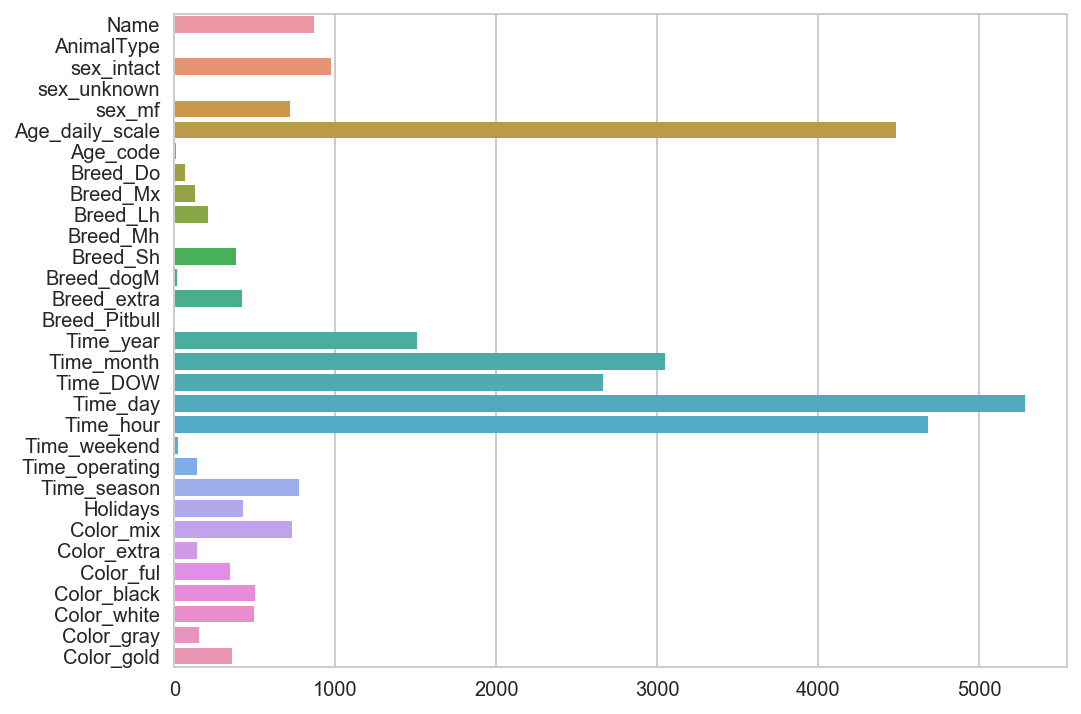

In [67]:
# 피쳐 중요도
importance = LGB_model.feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### 앙상블에 앙상블 얹기 - 랜덤포레스트 + LightGBM 

In [51]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,21,2):
    model1 = RandomForestClassifier(n_estimators=25, criterion='entropy', max_depth=i)
    model2 = lgb.LGBMClassifier(n_estimators=200, objective="multi:softprob", max_depth=i+5)
    ensemble = VotingClassifier(estimators=[('lr', model1),('pda', model2)], voting='soft', weights=[1,2]).fit(df_final,y)

    print(",",i,end="")
    model_ls.append(ensemble)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("Assemble Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#고양이 cv최고기록 : 0. RF + LGBM- n-esti:500// depth:-1// obj:'multi:softprob'// lr=0.5
#강아지 cv최고기록 : 0.618. RF:lr + LGBM:pda - n-esti:200// depth:14// obj:'multi:softprob'// weight=[1,2]
#종합 cv최고기록 : 0. RF + LGBM- n-esti:500// depth:-1// obj:'multi:softprob'// lr=0.5

model creating.., 1

KeyboardInterrupt: 

In [52]:
#### import lightgbm as lgb 

from sklearn.metrics import *

model1 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=14)
model2 = lgb.LGBMClassifier(n_estimators=200, objective="multi:softprob", max_depth=-1)
ASB_model =  VotingClassifier(estimators=[('lr', model1),('pda', model2)], voting='soft', weights=[1,2]).fit(df_final,y)

scores = cross_val_score(ASB_model, df_final, y,cv=10)
y_pred = ASB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("ASB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))


ASB Model4: Mean score: 0.618 --- acuraccy score : 0.785
- Confusion_Matrix 
 [[5833    0    3  583   78]
 [   0   50    0    0    0]
 [  75    0  516  186   68]
 [ 978    0    5 3169  134]
 [ 741    0    9  491 2676]]
                 precision    recall  f1-score   support

       Adoption       0.76      0.90      0.83      6497
           Died       1.00      1.00      1.00        50
     Euthanasia       0.97      0.61      0.75       845
Return_to_owner       0.72      0.74      0.73      4286
       Transfer       0.91      0.68      0.78      3917

    avg / total       0.80      0.79      0.78     15595



### 신경망 모델 Keras

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, random_state=0)

import tensorflow as tf
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)

print("입력갯수 :",len(X_train.columns))
# Y_test

Using TensorFlow backend.


입력갯수 : 32


In [75]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import regularizers

np.random.seed(0)

model0 = Sequential()
model0.add(Dense(50, input_dim=len(X_train.columns), activation="sigmoid")) # 레이어 1
model0.add(Dense(25, activation="sigmoid")) # 레이어 2
model0.add(Dense(5, activation="softmax")) # 레이어 3 --> dim 안서줘도 된다. 이전에 이미 했기때문에
model0.compile(optimizer=SGD(lr=3.2), loss='mean_squared_error', metrics=["accuracy"])

#고양이 최고기록 : acc:0.85, valacc:0.7532 l1- 50 sigmoid, l2- 25 sigmoid, l3- 5 sigmiod, epoch:3000
#강아지 최고기록 : 0.4732 
#종합 최고기록 : 0. 

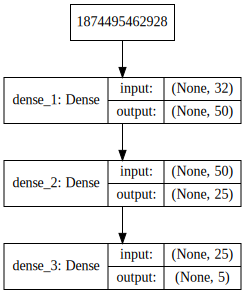

In [76]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/creal/graphviz-2.38/release/bin'

SVG(model_to_dot(model0, show_shapes=True).create(prog='dot', format='svg'))

In [77]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
Total params: 3,055
Trainable params: 3,055
Non-trainable params: 0
_________________________________________________________________


In [78]:
l1 = model0.layers[0]
l2 = model0.layers[1]

In [79]:
l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params()

('dense_1', keras.layers.core.Dense, (None, 50), 'sigmoid', 1650)

In [80]:
l2.name, type(l2), l2.output_shape, l2.activation.__name__, l2.count_params()

('dense_2', keras.layers.core.Dense, (None, 25), 'sigmoid', 1275)

In [81]:
%%time

# fit 메서드로 트레이닝 실시 (hist로 반환하면 그래프로 뿌리기 용이하다.)
hist = model0.fit(X_train, Y_train, 
                 epochs=3000, 
                 validation_data=(X_test, Y_test), 
                 verbose=2)

Train on 8907 samples, validate on 2227 samples
Epoch 1/3000
 - 1s - loss: 0.1259 - acc: 0.5164 - val_loss: 0.1124 - val_acc: 0.5667
Epoch 2/3000
 - 1s - loss: 0.1075 - acc: 0.6146 - val_loss: 0.1608 - val_acc: 0.4989
Epoch 3/3000
 - 1s - loss: 0.1027 - acc: 0.6432 - val_loss: 0.1179 - val_acc: 0.6048
Epoch 4/3000
 - 0s - loss: 0.1024 - acc: 0.6504 - val_loss: 0.0846 - val_acc: 0.7059
Epoch 5/3000
 - 0s - loss: 0.0962 - acc: 0.6751 - val_loss: 0.0856 - val_acc: 0.7099
Epoch 6/3000
 - 0s - loss: 0.0934 - acc: 0.6767 - val_loss: 0.0986 - val_acc: 0.6744
Epoch 7/3000
 - 0s - loss: 0.0880 - acc: 0.6978 - val_loss: 0.0750 - val_acc: 0.7512
Epoch 8/3000
 - 0s - loss: 0.0907 - acc: 0.6887 - val_loss: 0.0756 - val_acc: 0.7400
Epoch 9/3000
 - 0s - loss: 0.0854 - acc: 0.7021 - val_loss: 0.0764 - val_acc: 0.7283
Epoch 10/3000
 - 0s - loss: 0.0840 - acc: 0.7116 - val_loss: 0.0742 - val_acc: 0.7476
Epoch 11/3000
 - 0s - loss: 0.0826 - acc: 0.7166 - val_loss: 0.0897 - val_acc: 0.6974
Epoch 12/3000
 

Epoch 96/3000
 - 0s - loss: 0.0714 - acc: 0.7542 - val_loss: 0.0718 - val_acc: 0.7580
Epoch 97/3000
 - 0s - loss: 0.0724 - acc: 0.7512 - val_loss: 0.0749 - val_acc: 0.7472
Epoch 98/3000
 - 0s - loss: 0.0722 - acc: 0.7504 - val_loss: 0.0697 - val_acc: 0.7634
Epoch 99/3000
 - 0s - loss: 0.0720 - acc: 0.7527 - val_loss: 0.0737 - val_acc: 0.7427
Epoch 100/3000
 - 0s - loss: 0.0719 - acc: 0.7463 - val_loss: 0.0791 - val_acc: 0.7315
Epoch 101/3000
 - 1s - loss: 0.0713 - acc: 0.7526 - val_loss: 0.0752 - val_acc: 0.7364
Epoch 102/3000
 - 0s - loss: 0.0725 - acc: 0.7508 - val_loss: 0.0705 - val_acc: 0.7607
Epoch 103/3000
 - 0s - loss: 0.0724 - acc: 0.7473 - val_loss: 0.0735 - val_acc: 0.7485
Epoch 104/3000
 - 0s - loss: 0.0724 - acc: 0.7497 - val_loss: 0.0690 - val_acc: 0.7652
Epoch 105/3000
 - 0s - loss: 0.0718 - acc: 0.7515 - val_loss: 0.0837 - val_acc: 0.7063
Epoch 106/3000
 - 0s - loss: 0.0723 - acc: 0.7527 - val_loss: 0.0821 - val_acc: 0.7238
Epoch 107/3000
 - 0s - loss: 0.0732 - acc: 0.74

Epoch 191/3000
 - 0s - loss: 0.0682 - acc: 0.7616 - val_loss: 0.0686 - val_acc: 0.7647
Epoch 192/3000
 - 0s - loss: 0.0689 - acc: 0.7599 - val_loss: 0.0786 - val_acc: 0.7346
Epoch 193/3000
 - 0s - loss: 0.0681 - acc: 0.7645 - val_loss: 0.0659 - val_acc: 0.7759
Epoch 194/3000
 - 0s - loss: 0.0685 - acc: 0.7590 - val_loss: 0.0810 - val_acc: 0.7158
Epoch 195/3000
 - 0s - loss: 0.0680 - acc: 0.7615 - val_loss: 0.0693 - val_acc: 0.7647
Epoch 196/3000
 - 0s - loss: 0.0683 - acc: 0.7620 - val_loss: 0.0712 - val_acc: 0.7521
Epoch 197/3000
 - 0s - loss: 0.0690 - acc: 0.7570 - val_loss: 0.0681 - val_acc: 0.7665
Epoch 198/3000
 - 1s - loss: 0.0675 - acc: 0.7623 - val_loss: 0.0730 - val_acc: 0.7616
Epoch 199/3000
 - 1s - loss: 0.0683 - acc: 0.7628 - val_loss: 0.0782 - val_acc: 0.7167
Epoch 200/3000
 - 1s - loss: 0.0677 - acc: 0.7642 - val_loss: 0.0737 - val_acc: 0.7441
Epoch 201/3000
 - 0s - loss: 0.0682 - acc: 0.7659 - val_loss: 0.0724 - val_acc: 0.7566
Epoch 202/3000
 - 1s - loss: 0.0681 - acc: 

 - 0s - loss: 0.0645 - acc: 0.7788 - val_loss: 0.0728 - val_acc: 0.7557
Epoch 286/3000
 - 0s - loss: 0.0666 - acc: 0.7689 - val_loss: 0.0978 - val_acc: 0.6695
Epoch 287/3000
 - 0s - loss: 0.0656 - acc: 0.7705 - val_loss: 0.0671 - val_acc: 0.7710
Epoch 288/3000
 - 0s - loss: 0.0658 - acc: 0.7734 - val_loss: 0.0686 - val_acc: 0.7728
Epoch 289/3000
 - 0s - loss: 0.0661 - acc: 0.7689 - val_loss: 0.0737 - val_acc: 0.7441
Epoch 290/3000
 - 0s - loss: 0.0662 - acc: 0.7709 - val_loss: 0.0683 - val_acc: 0.7625
Epoch 291/3000
 - 0s - loss: 0.0664 - acc: 0.7704 - val_loss: 0.1055 - val_acc: 0.6700
Epoch 292/3000
 - 0s - loss: 0.0659 - acc: 0.7720 - val_loss: 0.0721 - val_acc: 0.7485
Epoch 293/3000
 - 0s - loss: 0.0657 - acc: 0.7725 - val_loss: 0.0759 - val_acc: 0.7355
Epoch 294/3000
 - 0s - loss: 0.0653 - acc: 0.7716 - val_loss: 0.0677 - val_acc: 0.7696
Epoch 295/3000
 - 0s - loss: 0.0651 - acc: 0.7756 - val_loss: 0.0737 - val_acc: 0.7508
Epoch 296/3000
 - 0s - loss: 0.0659 - acc: 0.7692 - val_lo

Epoch 380/3000
 - 0s - loss: 0.0660 - acc: 0.7689 - val_loss: 0.0737 - val_acc: 0.7445
Epoch 381/3000
 - 0s - loss: 0.0646 - acc: 0.7746 - val_loss: 0.0741 - val_acc: 0.7454
Epoch 382/3000
 - 0s - loss: 0.0653 - acc: 0.7732 - val_loss: 0.0680 - val_acc: 0.7620
Epoch 383/3000
 - 0s - loss: 0.0648 - acc: 0.7776 - val_loss: 0.0687 - val_acc: 0.7458
Epoch 384/3000
 - 0s - loss: 0.0656 - acc: 0.7712 - val_loss: 0.0854 - val_acc: 0.7288
Epoch 385/3000
 - 1s - loss: 0.0654 - acc: 0.7747 - val_loss: 0.0668 - val_acc: 0.7714
Epoch 386/3000
 - 1s - loss: 0.0642 - acc: 0.7784 - val_loss: 0.1045 - val_acc: 0.6529
Epoch 387/3000
 - 0s - loss: 0.0641 - acc: 0.7762 - val_loss: 0.0756 - val_acc: 0.7553
Epoch 388/3000
 - 1s - loss: 0.0638 - acc: 0.7787 - val_loss: 0.0671 - val_acc: 0.7678
Epoch 389/3000
 - 1s - loss: 0.0642 - acc: 0.7799 - val_loss: 0.0832 - val_acc: 0.7261
Epoch 390/3000
 - 0s - loss: 0.0652 - acc: 0.7722 - val_loss: 0.0910 - val_acc: 0.6906
Epoch 391/3000
 - 0s - loss: 0.0651 - acc: 

 - 0s - loss: 0.0617 - acc: 0.7870 - val_loss: 0.0674 - val_acc: 0.7705
Epoch 475/3000
 - 0s - loss: 0.0611 - acc: 0.7925 - val_loss: 0.0779 - val_acc: 0.7414
Epoch 476/3000
 - 0s - loss: 0.0619 - acc: 0.7859 - val_loss: 0.0755 - val_acc: 0.7391
Epoch 477/3000
 - 0s - loss: 0.0628 - acc: 0.7835 - val_loss: 0.0690 - val_acc: 0.7670
Epoch 478/3000
 - 0s - loss: 0.0623 - acc: 0.7846 - val_loss: 0.0791 - val_acc: 0.7225
Epoch 479/3000
 - 0s - loss: 0.0626 - acc: 0.7804 - val_loss: 0.0665 - val_acc: 0.7759
Epoch 480/3000
 - 0s - loss: 0.0622 - acc: 0.7844 - val_loss: 0.0765 - val_acc: 0.7485
Epoch 481/3000
 - 0s - loss: 0.0624 - acc: 0.7889 - val_loss: 0.0863 - val_acc: 0.7153
Epoch 482/3000
 - 0s - loss: 0.0618 - acc: 0.7874 - val_loss: 0.0675 - val_acc: 0.7723
Epoch 483/3000
 - 0s - loss: 0.0625 - acc: 0.7833 - val_loss: 0.0773 - val_acc: 0.7427
Epoch 484/3000
 - 0s - loss: 0.0627 - acc: 0.7850 - val_loss: 0.0724 - val_acc: 0.7517
Epoch 485/3000
 - 0s - loss: 0.0625 - acc: 0.7815 - val_lo

Epoch 569/3000
 - 0s - loss: 0.0615 - acc: 0.7867 - val_loss: 0.0829 - val_acc: 0.7288
Epoch 570/3000
 - 0s - loss: 0.0616 - acc: 0.7859 - val_loss: 0.0746 - val_acc: 0.7342
Epoch 571/3000
 - 0s - loss: 0.0619 - acc: 0.7868 - val_loss: 0.0703 - val_acc: 0.7625
Epoch 572/3000
 - 1s - loss: 0.0617 - acc: 0.7888 - val_loss: 0.0691 - val_acc: 0.7634
Epoch 573/3000
 - 1s - loss: 0.0618 - acc: 0.7848 - val_loss: 0.0832 - val_acc: 0.6982
Epoch 574/3000
 - 0s - loss: 0.0621 - acc: 0.7819 - val_loss: 0.0859 - val_acc: 0.6897
Epoch 575/3000
 - 0s - loss: 0.0615 - acc: 0.7874 - val_loss: 0.0711 - val_acc: 0.7539
Epoch 576/3000
 - 1s - loss: 0.0612 - acc: 0.7870 - val_loss: 0.0691 - val_acc: 0.7638
Epoch 577/3000
 - 1s - loss: 0.0607 - acc: 0.7936 - val_loss: 0.0683 - val_acc: 0.7580
Epoch 578/3000
 - 1s - loss: 0.0613 - acc: 0.7920 - val_loss: 0.0733 - val_acc: 0.7476
Epoch 579/3000
 - 1s - loss: 0.0608 - acc: 0.7906 - val_loss: 0.0693 - val_acc: 0.7647
Epoch 580/3000
 - 1s - loss: 0.0611 - acc: 

 - 1s - loss: 0.0609 - acc: 0.7896 - val_loss: 0.0722 - val_acc: 0.7530
Epoch 664/3000
 - 1s - loss: 0.0618 - acc: 0.7842 - val_loss: 0.0666 - val_acc: 0.7759
Epoch 665/3000
 - 0s - loss: 0.0612 - acc: 0.7911 - val_loss: 0.0811 - val_acc: 0.7418
Epoch 666/3000
 - 1s - loss: 0.0605 - acc: 0.7914 - val_loss: 0.0674 - val_acc: 0.7741
Epoch 667/3000
 - 1s - loss: 0.0599 - acc: 0.7942 - val_loss: 0.0729 - val_acc: 0.7436
Epoch 668/3000
 - 1s - loss: 0.0608 - acc: 0.7914 - val_loss: 0.0653 - val_acc: 0.7809
Epoch 669/3000
 - 1s - loss: 0.0588 - acc: 0.7967 - val_loss: 0.0658 - val_acc: 0.7656
Epoch 670/3000
 - 0s - loss: 0.0600 - acc: 0.7942 - val_loss: 0.0694 - val_acc: 0.7741
Epoch 671/3000
 - 1s - loss: 0.0592 - acc: 0.7959 - val_loss: 0.0685 - val_acc: 0.7687
Epoch 672/3000
 - 0s - loss: 0.0587 - acc: 0.7988 - val_loss: 0.0740 - val_acc: 0.7423
Epoch 673/3000
 - 0s - loss: 0.0605 - acc: 0.7924 - val_loss: 0.0721 - val_acc: 0.7607
Epoch 674/3000
 - 0s - loss: 0.0587 - acc: 0.7987 - val_lo

Epoch 758/3000
 - 0s - loss: 0.0584 - acc: 0.7982 - val_loss: 0.0709 - val_acc: 0.7454
Epoch 759/3000
 - 0s - loss: 0.0586 - acc: 0.7999 - val_loss: 0.0686 - val_acc: 0.7714
Epoch 760/3000
 - 0s - loss: 0.0586 - acc: 0.8004 - val_loss: 0.0720 - val_acc: 0.7580
Epoch 761/3000
 - 0s - loss: 0.0602 - acc: 0.7903 - val_loss: 0.0764 - val_acc: 0.7427
Epoch 762/3000
 - 0s - loss: 0.0601 - acc: 0.7920 - val_loss: 0.0763 - val_acc: 0.7400
Epoch 763/3000
 - 0s - loss: 0.0592 - acc: 0.7976 - val_loss: 0.0648 - val_acc: 0.7786
Epoch 764/3000
 - 0s - loss: 0.0585 - acc: 0.7987 - val_loss: 0.0680 - val_acc: 0.7656
Epoch 765/3000
 - 0s - loss: 0.0590 - acc: 0.7986 - val_loss: 0.0767 - val_acc: 0.7396
Epoch 766/3000
 - 0s - loss: 0.0587 - acc: 0.7975 - val_loss: 0.0765 - val_acc: 0.7405
Epoch 767/3000
 - 0s - loss: 0.0586 - acc: 0.7994 - val_loss: 0.0693 - val_acc: 0.7476
Epoch 768/3000
 - 0s - loss: 0.0591 - acc: 0.7982 - val_loss: 0.0684 - val_acc: 0.7656
Epoch 769/3000
 - 0s - loss: 0.0593 - acc: 

 - 0s - loss: 0.0569 - acc: 0.8071 - val_loss: 0.0744 - val_acc: 0.7346
Epoch 853/3000
 - 0s - loss: 0.0564 - acc: 0.8064 - val_loss: 0.0698 - val_acc: 0.7584
Epoch 854/3000
 - 0s - loss: 0.0552 - acc: 0.8128 - val_loss: 0.0698 - val_acc: 0.7566
Epoch 855/3000
 - 1s - loss: 0.0566 - acc: 0.8061 - val_loss: 0.0742 - val_acc: 0.7467
Epoch 856/3000
 - 1s - loss: 0.0563 - acc: 0.8078 - val_loss: 0.0788 - val_acc: 0.7140
Epoch 857/3000
 - 0s - loss: 0.0560 - acc: 0.8082 - val_loss: 0.0694 - val_acc: 0.7593
Epoch 858/3000
 - 0s - loss: 0.0574 - acc: 0.8041 - val_loss: 0.0676 - val_acc: 0.7692
Epoch 859/3000
 - 0s - loss: 0.0577 - acc: 0.8026 - val_loss: 0.0694 - val_acc: 0.7705
Epoch 860/3000
 - 0s - loss: 0.0557 - acc: 0.8108 - val_loss: 0.0675 - val_acc: 0.7768
Epoch 861/3000
 - 0s - loss: 0.0569 - acc: 0.8052 - val_loss: 0.0794 - val_acc: 0.7400
Epoch 862/3000
 - 1s - loss: 0.0566 - acc: 0.8046 - val_loss: 0.0704 - val_acc: 0.7602
Epoch 863/3000
 - 0s - loss: 0.0563 - acc: 0.8068 - val_lo

Epoch 947/3000
 - 0s - loss: 0.0553 - acc: 0.8100 - val_loss: 0.0777 - val_acc: 0.7414
Epoch 948/3000
 - 0s - loss: 0.0566 - acc: 0.8026 - val_loss: 0.0674 - val_acc: 0.7750
Epoch 949/3000
 - 0s - loss: 0.0562 - acc: 0.8103 - val_loss: 0.0696 - val_acc: 0.7557
Epoch 950/3000
 - 0s - loss: 0.0558 - acc: 0.8117 - val_loss: 0.0728 - val_acc: 0.7620
Epoch 951/3000
 - 0s - loss: 0.0553 - acc: 0.8109 - val_loss: 0.0725 - val_acc: 0.7445
Epoch 952/3000
 - 0s - loss: 0.0561 - acc: 0.8050 - val_loss: 0.0679 - val_acc: 0.7696
Epoch 953/3000
 - 0s - loss: 0.0554 - acc: 0.8124 - val_loss: 0.0685 - val_acc: 0.7728
Epoch 954/3000
 - 0s - loss: 0.0553 - acc: 0.8121 - val_loss: 0.0679 - val_acc: 0.7755
Epoch 955/3000
 - 0s - loss: 0.0553 - acc: 0.8096 - val_loss: 0.0676 - val_acc: 0.7759
Epoch 956/3000
 - 0s - loss: 0.0541 - acc: 0.8162 - val_loss: 0.0661 - val_acc: 0.7764
Epoch 957/3000
 - 0s - loss: 0.0545 - acc: 0.8162 - val_loss: 0.0872 - val_acc: 0.6947
Epoch 958/3000
 - 0s - loss: 0.0559 - acc: 

Epoch 1041/3000
 - 0s - loss: 0.0546 - acc: 0.8142 - val_loss: 0.0711 - val_acc: 0.7647
Epoch 1042/3000
 - 0s - loss: 0.0534 - acc: 0.8205 - val_loss: 0.0676 - val_acc: 0.7791
Epoch 1043/3000
 - 0s - loss: 0.0539 - acc: 0.8173 - val_loss: 0.0706 - val_acc: 0.7665
Epoch 1044/3000
 - 0s - loss: 0.0540 - acc: 0.8153 - val_loss: 0.0700 - val_acc: 0.7719
Epoch 1045/3000
 - 0s - loss: 0.0539 - acc: 0.8183 - val_loss: 0.0692 - val_acc: 0.7737
Epoch 1046/3000
 - 0s - loss: 0.0553 - acc: 0.8105 - val_loss: 0.0662 - val_acc: 0.7813
Epoch 1047/3000
 - 0s - loss: 0.0534 - acc: 0.8198 - val_loss: 0.0678 - val_acc: 0.7678
Epoch 1048/3000
 - 0s - loss: 0.0527 - acc: 0.8223 - val_loss: 0.0717 - val_acc: 0.7521
Epoch 1049/3000
 - 0s - loss: 0.0538 - acc: 0.8197 - val_loss: 0.0690 - val_acc: 0.7652
Epoch 1050/3000
 - 0s - loss: 0.0547 - acc: 0.8148 - val_loss: 0.0692 - val_acc: 0.7665
Epoch 1051/3000
 - 0s - loss: 0.0547 - acc: 0.8135 - val_loss: 0.0685 - val_acc: 0.7732
Epoch 1052/3000
 - 0s - loss: 0.

 - 1s - loss: 0.0533 - acc: 0.8191 - val_loss: 0.0695 - val_acc: 0.7674
Epoch 1135/3000
 - 1s - loss: 0.0533 - acc: 0.8178 - val_loss: 0.0719 - val_acc: 0.7705
Epoch 1136/3000
 - 1s - loss: 0.0536 - acc: 0.8173 - val_loss: 0.0728 - val_acc: 0.7530
Epoch 1137/3000
 - 1s - loss: 0.0544 - acc: 0.8131 - val_loss: 0.0759 - val_acc: 0.7292
Epoch 1138/3000
 - 1s - loss: 0.0556 - acc: 0.8124 - val_loss: 0.0702 - val_acc: 0.7598
Epoch 1139/3000
 - 1s - loss: 0.0537 - acc: 0.8186 - val_loss: 0.0737 - val_acc: 0.7463
Epoch 1140/3000
 - 1s - loss: 0.0543 - acc: 0.8144 - val_loss: 0.0710 - val_acc: 0.7701
Epoch 1141/3000
 - 1s - loss: 0.0536 - acc: 0.8207 - val_loss: 0.0704 - val_acc: 0.7589
Epoch 1142/3000
 - 1s - loss: 0.0523 - acc: 0.8234 - val_loss: 0.0772 - val_acc: 0.7441
Epoch 1143/3000
 - 1s - loss: 0.0547 - acc: 0.8161 - val_loss: 0.0672 - val_acc: 0.7750
Epoch 1144/3000
 - 1s - loss: 0.0538 - acc: 0.8162 - val_loss: 0.0684 - val_acc: 0.7818
Epoch 1145/3000
 - 1s - loss: 0.0526 - acc: 0.81

Epoch 1228/3000
 - 0s - loss: 0.0543 - acc: 0.8150 - val_loss: 0.0711 - val_acc: 0.7652
Epoch 1229/3000
 - 0s - loss: 0.0524 - acc: 0.8234 - val_loss: 0.0716 - val_acc: 0.7589
Epoch 1230/3000
 - 0s - loss: 0.0530 - acc: 0.8194 - val_loss: 0.0764 - val_acc: 0.7279
Epoch 1231/3000
 - 0s - loss: 0.0534 - acc: 0.8204 - val_loss: 0.0692 - val_acc: 0.7692
Epoch 1232/3000
 - 0s - loss: 0.0520 - acc: 0.8229 - val_loss: 0.0855 - val_acc: 0.7135
Epoch 1233/3000
 - 0s - loss: 0.0520 - acc: 0.8249 - val_loss: 0.0837 - val_acc: 0.7207
Epoch 1234/3000
 - 0s - loss: 0.0526 - acc: 0.8215 - val_loss: 0.0695 - val_acc: 0.7723
Epoch 1235/3000
 - 1s - loss: 0.0540 - acc: 0.8161 - val_loss: 0.0701 - val_acc: 0.7670
Epoch 1236/3000
 - 1s - loss: 0.0521 - acc: 0.8247 - val_loss: 0.0724 - val_acc: 0.7508
Epoch 1237/3000
 - 0s - loss: 0.0525 - acc: 0.8233 - val_loss: 0.0750 - val_acc: 0.7557
Epoch 1238/3000
 - 0s - loss: 0.0553 - acc: 0.8139 - val_loss: 0.0683 - val_acc: 0.7656
Epoch 1239/3000
 - 1s - loss: 0.

 - 0s - loss: 0.0516 - acc: 0.8265 - val_loss: 0.0697 - val_acc: 0.7638
Epoch 1322/3000
 - 0s - loss: 0.0504 - acc: 0.8313 - val_loss: 0.0735 - val_acc: 0.7512
Epoch 1323/3000
 - 1s - loss: 0.0503 - acc: 0.8309 - val_loss: 0.0771 - val_acc: 0.7396
Epoch 1324/3000
 - 1s - loss: 0.0511 - acc: 0.8272 - val_loss: 0.0704 - val_acc: 0.7575
Epoch 1325/3000
 - 1s - loss: 0.0509 - acc: 0.8256 - val_loss: 0.0685 - val_acc: 0.7723
Epoch 1326/3000
 - 1s - loss: 0.0522 - acc: 0.8223 - val_loss: 0.0717 - val_acc: 0.7701
Epoch 1327/3000
 - 1s - loss: 0.0530 - acc: 0.8210 - val_loss: 0.0731 - val_acc: 0.7656
Epoch 1328/3000
 - 1s - loss: 0.0513 - acc: 0.8309 - val_loss: 0.0779 - val_acc: 0.7337
Epoch 1329/3000
 - 0s - loss: 0.0516 - acc: 0.8259 - val_loss: 0.0718 - val_acc: 0.7647
Epoch 1330/3000
 - 0s - loss: 0.0519 - acc: 0.8262 - val_loss: 0.0743 - val_acc: 0.7584
Epoch 1331/3000
 - 1s - loss: 0.0514 - acc: 0.8258 - val_loss: 0.0699 - val_acc: 0.7732
Epoch 1332/3000
 - 1s - loss: 0.0508 - acc: 0.82

Epoch 1415/3000
 - 1s - loss: 0.0500 - acc: 0.8317 - val_loss: 0.0709 - val_acc: 0.7620
Epoch 1416/3000
 - 1s - loss: 0.0497 - acc: 0.8350 - val_loss: 0.0773 - val_acc: 0.7292
Epoch 1417/3000
 - 1s - loss: 0.0509 - acc: 0.8276 - val_loss: 0.0705 - val_acc: 0.7629
Epoch 1418/3000
 - 1s - loss: 0.0506 - acc: 0.8311 - val_loss: 0.0742 - val_acc: 0.7539
Epoch 1419/3000
 - 0s - loss: 0.0511 - acc: 0.8284 - val_loss: 0.0705 - val_acc: 0.7692
Epoch 1420/3000
 - 1s - loss: 0.0512 - acc: 0.8260 - val_loss: 0.0745 - val_acc: 0.7544
Epoch 1421/3000
 - 1s - loss: 0.0506 - acc: 0.8277 - val_loss: 0.0712 - val_acc: 0.7723
Epoch 1422/3000
 - 1s - loss: 0.0513 - acc: 0.8267 - val_loss: 0.0755 - val_acc: 0.7557
Epoch 1423/3000
 - 1s - loss: 0.0502 - acc: 0.8309 - val_loss: 0.0740 - val_acc: 0.7593
Epoch 1424/3000
 - 1s - loss: 0.0503 - acc: 0.8290 - val_loss: 0.0714 - val_acc: 0.7593
Epoch 1425/3000
 - 1s - loss: 0.0519 - acc: 0.8264 - val_loss: 0.0725 - val_acc: 0.7705
Epoch 1426/3000
 - 0s - loss: 0.

 - 0s - loss: 0.0548 - acc: 0.8121 - val_loss: 0.0721 - val_acc: 0.7719
Epoch 1509/3000
 - 0s - loss: 0.0519 - acc: 0.8209 - val_loss: 0.0696 - val_acc: 0.7732
Epoch 1510/3000
 - 0s - loss: 0.0513 - acc: 0.8262 - val_loss: 0.0718 - val_acc: 0.7710
Epoch 1511/3000
 - 0s - loss: 0.0518 - acc: 0.8250 - val_loss: 0.0777 - val_acc: 0.7472
Epoch 1512/3000
 - 0s - loss: 0.0501 - acc: 0.8305 - val_loss: 0.0807 - val_acc: 0.7297
Epoch 1513/3000
 - 0s - loss: 0.0533 - acc: 0.8185 - val_loss: 0.0688 - val_acc: 0.7773
Epoch 1514/3000
 - 0s - loss: 0.0540 - acc: 0.8180 - val_loss: 0.0876 - val_acc: 0.7153
Epoch 1515/3000
 - 0s - loss: 0.0528 - acc: 0.8204 - val_loss: 0.0714 - val_acc: 0.7687
Epoch 1516/3000
 - 0s - loss: 0.0532 - acc: 0.8176 - val_loss: 0.0767 - val_acc: 0.7418
Epoch 1517/3000
 - 0s - loss: 0.0509 - acc: 0.8253 - val_loss: 0.0787 - val_acc: 0.7265
Epoch 1518/3000
 - 0s - loss: 0.0501 - acc: 0.8299 - val_loss: 0.0897 - val_acc: 0.6906
Epoch 1519/3000
 - 0s - loss: 0.0517 - acc: 0.82

Epoch 1602/3000
 - 0s - loss: 0.0532 - acc: 0.8206 - val_loss: 0.0732 - val_acc: 0.7598
Epoch 1603/3000
 - 0s - loss: 0.0500 - acc: 0.8328 - val_loss: 0.0724 - val_acc: 0.7607
Epoch 1604/3000
 - 0s - loss: 0.0494 - acc: 0.8331 - val_loss: 0.0724 - val_acc: 0.7602
Epoch 1605/3000
 - 0s - loss: 0.0495 - acc: 0.8329 - val_loss: 0.0774 - val_acc: 0.7373
Epoch 1606/3000
 - 0s - loss: 0.0508 - acc: 0.8280 - val_loss: 0.0726 - val_acc: 0.7598
Epoch 1607/3000
 - 0s - loss: 0.0508 - acc: 0.8276 - val_loss: 0.0711 - val_acc: 0.7535
Epoch 1608/3000
 - 0s - loss: 0.0518 - acc: 0.8240 - val_loss: 0.0722 - val_acc: 0.7661
Epoch 1609/3000
 - 0s - loss: 0.0508 - acc: 0.8283 - val_loss: 0.0713 - val_acc: 0.7611
Epoch 1610/3000
 - 0s - loss: 0.0504 - acc: 0.8301 - val_loss: 0.0742 - val_acc: 0.7544
Epoch 1611/3000
 - 0s - loss: 0.0526 - acc: 0.8219 - val_loss: 0.0709 - val_acc: 0.7692
Epoch 1612/3000
 - 1s - loss: 0.0512 - acc: 0.8253 - val_loss: 0.0741 - val_acc: 0.7485
Epoch 1613/3000
 - 0s - loss: 0.

 - 1s - loss: 0.0521 - acc: 0.8242 - val_loss: 0.0791 - val_acc: 0.7315
Epoch 1696/3000
 - 1s - loss: 0.0521 - acc: 0.8235 - val_loss: 0.0754 - val_acc: 0.7562
Epoch 1697/3000
 - 1s - loss: 0.0531 - acc: 0.8195 - val_loss: 0.0758 - val_acc: 0.7485
Epoch 1698/3000
 - 1s - loss: 0.0528 - acc: 0.8215 - val_loss: 0.0772 - val_acc: 0.7458
Epoch 1699/3000
 - 1s - loss: 0.0512 - acc: 0.8268 - val_loss: 0.0713 - val_acc: 0.7593
Epoch 1700/3000
 - 1s - loss: 0.0530 - acc: 0.8196 - val_loss: 0.0840 - val_acc: 0.7247
Epoch 1701/3000
 - 0s - loss: 0.0537 - acc: 0.8203 - val_loss: 0.1024 - val_acc: 0.6569
Epoch 1702/3000
 - 0s - loss: 0.0553 - acc: 0.8169 - val_loss: 0.0745 - val_acc: 0.7530
Epoch 1703/3000
 - 0s - loss: 0.0542 - acc: 0.8170 - val_loss: 0.0726 - val_acc: 0.7602
Epoch 1704/3000
 - 0s - loss: 0.0524 - acc: 0.8252 - val_loss: 0.0731 - val_acc: 0.7611
Epoch 1705/3000
 - 0s - loss: 0.0525 - acc: 0.8224 - val_loss: 0.0885 - val_acc: 0.6987
Epoch 1706/3000
 - 0s - loss: 0.0516 - acc: 0.82

Epoch 1789/3000
 - 0s - loss: 0.0529 - acc: 0.8223 - val_loss: 0.0835 - val_acc: 0.7207
Epoch 1790/3000
 - 0s - loss: 0.0588 - acc: 0.8004 - val_loss: 0.0728 - val_acc: 0.7557
Epoch 1791/3000
 - 0s - loss: 0.0545 - acc: 0.8126 - val_loss: 0.0763 - val_acc: 0.7423
Epoch 1792/3000
 - 0s - loss: 0.0539 - acc: 0.8204 - val_loss: 0.0893 - val_acc: 0.7185
Epoch 1793/3000
 - 0s - loss: 0.0525 - acc: 0.8223 - val_loss: 0.0776 - val_acc: 0.7472
Epoch 1794/3000
 - 0s - loss: 0.0503 - acc: 0.8316 - val_loss: 0.0775 - val_acc: 0.7571
Epoch 1795/3000
 - 0s - loss: 0.0494 - acc: 0.8351 - val_loss: 0.0732 - val_acc: 0.7661
Epoch 1796/3000
 - 0s - loss: 0.0492 - acc: 0.8347 - val_loss: 0.0789 - val_acc: 0.7283
Epoch 1797/3000
 - 0s - loss: 0.0501 - acc: 0.8326 - val_loss: 0.0753 - val_acc: 0.7598
Epoch 1798/3000
 - 0s - loss: 0.0500 - acc: 0.8302 - val_loss: 0.0766 - val_acc: 0.7346
Epoch 1799/3000
 - 0s - loss: 0.0494 - acc: 0.8320 - val_loss: 0.0711 - val_acc: 0.7661
Epoch 1800/3000
 - 0s - loss: 0.

 - 0s - loss: 0.0493 - acc: 0.8329 - val_loss: 0.0712 - val_acc: 0.7593
Epoch 1883/3000
 - 0s - loss: 0.0492 - acc: 0.8348 - val_loss: 0.0712 - val_acc: 0.7683
Epoch 1884/3000
 - 0s - loss: 0.0498 - acc: 0.8307 - val_loss: 0.0757 - val_acc: 0.7476
Epoch 1885/3000
 - 0s - loss: 0.0492 - acc: 0.8381 - val_loss: 0.0729 - val_acc: 0.7647
Epoch 1886/3000
 - 0s - loss: 0.0502 - acc: 0.8316 - val_loss: 0.0778 - val_acc: 0.7297
Epoch 1887/3000
 - 0s - loss: 0.0497 - acc: 0.8314 - val_loss: 0.0727 - val_acc: 0.7602
Epoch 1888/3000
 - 0s - loss: 0.0496 - acc: 0.8331 - val_loss: 0.0724 - val_acc: 0.7647
Epoch 1889/3000
 - 0s - loss: 0.0495 - acc: 0.8320 - val_loss: 0.0814 - val_acc: 0.7414
Epoch 1890/3000
 - 0s - loss: 0.0504 - acc: 0.8293 - val_loss: 0.0802 - val_acc: 0.7449
Epoch 1891/3000
 - 0s - loss: 0.0486 - acc: 0.8370 - val_loss: 0.0719 - val_acc: 0.7652
Epoch 1892/3000
 - 0s - loss: 0.0487 - acc: 0.8377 - val_loss: 0.0761 - val_acc: 0.7485
Epoch 1893/3000
 - 0s - loss: 0.0495 - acc: 0.82

Epoch 1976/3000
 - 0s - loss: 0.0510 - acc: 0.8279 - val_loss: 0.0754 - val_acc: 0.7458
Epoch 1977/3000
 - 0s - loss: 0.0507 - acc: 0.8278 - val_loss: 0.0709 - val_acc: 0.7661
Epoch 1978/3000
 - 0s - loss: 0.0490 - acc: 0.8345 - val_loss: 0.0726 - val_acc: 0.7517
Epoch 1979/3000
 - 0s - loss: 0.0512 - acc: 0.8271 - val_loss: 0.0751 - val_acc: 0.7598
Epoch 1980/3000
 - 0s - loss: 0.0498 - acc: 0.8300 - val_loss: 0.0701 - val_acc: 0.7692
Epoch 1981/3000
 - 0s - loss: 0.0503 - acc: 0.8297 - val_loss: 0.0744 - val_acc: 0.7499
Epoch 1982/3000
 - 0s - loss: 0.0493 - acc: 0.8361 - val_loss: 0.0714 - val_acc: 0.7665
Epoch 1983/3000
 - 0s - loss: 0.0498 - acc: 0.8320 - val_loss: 0.0751 - val_acc: 0.7400
Epoch 1984/3000
 - 1s - loss: 0.0504 - acc: 0.8287 - val_loss: 0.0741 - val_acc: 0.7508
Epoch 1985/3000
 - 0s - loss: 0.0506 - acc: 0.8281 - val_loss: 0.0827 - val_acc: 0.7131
Epoch 1986/3000
 - 0s - loss: 0.0499 - acc: 0.8309 - val_loss: 0.0740 - val_acc: 0.7454
Epoch 1987/3000
 - 0s - loss: 0.

 - 1s - loss: 0.0561 - acc: 0.8122 - val_loss: 0.0780 - val_acc: 0.7391
Epoch 2070/3000
 - 0s - loss: 0.0567 - acc: 0.8106 - val_loss: 0.0771 - val_acc: 0.7387
Epoch 2071/3000
 - 0s - loss: 0.0560 - acc: 0.8109 - val_loss: 0.0905 - val_acc: 0.6884
Epoch 2072/3000
 - 0s - loss: 0.0560 - acc: 0.8124 - val_loss: 0.0748 - val_acc: 0.7441
Epoch 2073/3000
 - 0s - loss: 0.0549 - acc: 0.8161 - val_loss: 0.0726 - val_acc: 0.7598
Epoch 2074/3000
 - 0s - loss: 0.0532 - acc: 0.8214 - val_loss: 0.0748 - val_acc: 0.7472
Epoch 2075/3000
 - 0s - loss: 0.0544 - acc: 0.8173 - val_loss: 0.0741 - val_acc: 0.7575
Epoch 2076/3000
 - 0s - loss: 0.0535 - acc: 0.8200 - val_loss: 0.0747 - val_acc: 0.7562
Epoch 2077/3000
 - 0s - loss: 0.0530 - acc: 0.8225 - val_loss: 0.0723 - val_acc: 0.7661
Epoch 2078/3000
 - 0s - loss: 0.0511 - acc: 0.8302 - val_loss: 0.0745 - val_acc: 0.7625
Epoch 2079/3000
 - 0s - loss: 0.0523 - acc: 0.8244 - val_loss: 0.0767 - val_acc: 0.7476
Epoch 2080/3000
 - 0s - loss: 0.0514 - acc: 0.82

Epoch 2163/3000
 - 0s - loss: 0.0481 - acc: 0.8365 - val_loss: 0.0725 - val_acc: 0.7526
Epoch 2164/3000
 - 0s - loss: 0.0487 - acc: 0.8382 - val_loss: 0.0726 - val_acc: 0.7710
Epoch 2165/3000
 - 0s - loss: 0.0516 - acc: 0.8259 - val_loss: 0.0769 - val_acc: 0.7562
Epoch 2166/3000
 - 0s - loss: 0.0496 - acc: 0.8340 - val_loss: 0.0748 - val_acc: 0.7463
Epoch 2167/3000
 - 0s - loss: 0.0499 - acc: 0.8324 - val_loss: 0.0797 - val_acc: 0.7423
Epoch 2168/3000
 - 0s - loss: 0.0543 - acc: 0.8171 - val_loss: 0.0860 - val_acc: 0.7243
Epoch 2169/3000
 - 0s - loss: 0.0517 - acc: 0.8289 - val_loss: 0.0730 - val_acc: 0.7593
Epoch 2170/3000
 - 0s - loss: 0.0520 - acc: 0.8242 - val_loss: 0.0758 - val_acc: 0.7535
Epoch 2171/3000
 - 0s - loss: 0.0584 - acc: 0.8030 - val_loss: 0.0746 - val_acc: 0.7499
Epoch 2172/3000
 - 0s - loss: 0.0563 - acc: 0.8112 - val_loss: 0.0818 - val_acc: 0.7400
Epoch 2173/3000
 - 0s - loss: 0.0583 - acc: 0.8051 - val_loss: 0.0772 - val_acc: 0.7548
Epoch 2174/3000
 - 0s - loss: 0.

 - 0s - loss: 0.0493 - acc: 0.8350 - val_loss: 0.0706 - val_acc: 0.7661
Epoch 2257/3000
 - 1s - loss: 0.0476 - acc: 0.8435 - val_loss: 0.0755 - val_acc: 0.7432
Epoch 2258/3000
 - 0s - loss: 0.0481 - acc: 0.8397 - val_loss: 0.0728 - val_acc: 0.7611
Epoch 2259/3000
 - 0s - loss: 0.0498 - acc: 0.8345 - val_loss: 0.0774 - val_acc: 0.7436
Epoch 2260/3000
 - 1s - loss: 0.0486 - acc: 0.8391 - val_loss: 0.0738 - val_acc: 0.7526
Epoch 2261/3000
 - 1s - loss: 0.0497 - acc: 0.8337 - val_loss: 0.0802 - val_acc: 0.7373
Epoch 2262/3000
 - 1s - loss: 0.0490 - acc: 0.8357 - val_loss: 0.0732 - val_acc: 0.7616
Epoch 2263/3000
 - 1s - loss: 0.0486 - acc: 0.8372 - val_loss: 0.0731 - val_acc: 0.7714
Epoch 2264/3000
 - 1s - loss: 0.0483 - acc: 0.8428 - val_loss: 0.0757 - val_acc: 0.7494
Epoch 2265/3000
 - 0s - loss: 0.0489 - acc: 0.8361 - val_loss: 0.0725 - val_acc: 0.7611
Epoch 2266/3000
 - 0s - loss: 0.0482 - acc: 0.8420 - val_loss: 0.0729 - val_acc: 0.7656
Epoch 2267/3000
 - 1s - loss: 0.0498 - acc: 0.83

Epoch 2350/3000
 - 1s - loss: 0.0482 - acc: 0.8384 - val_loss: 0.0726 - val_acc: 0.7634
Epoch 2351/3000
 - 1s - loss: 0.0480 - acc: 0.8381 - val_loss: 0.0748 - val_acc: 0.7584
Epoch 2352/3000
 - 1s - loss: 0.0476 - acc: 0.8421 - val_loss: 0.0938 - val_acc: 0.6978
Epoch 2353/3000
 - 1s - loss: 0.0503 - acc: 0.8322 - val_loss: 0.0750 - val_acc: 0.7602
Epoch 2354/3000
 - 1s - loss: 0.0492 - acc: 0.8353 - val_loss: 0.0753 - val_acc: 0.7557
Epoch 2355/3000
 - 1s - loss: 0.0497 - acc: 0.8352 - val_loss: 0.0730 - val_acc: 0.7634
Epoch 2356/3000
 - 1s - loss: 0.0508 - acc: 0.8289 - val_loss: 0.0829 - val_acc: 0.7229
Epoch 2357/3000
 - 1s - loss: 0.0519 - acc: 0.8207 - val_loss: 0.0715 - val_acc: 0.7732
Epoch 2358/3000
 - 1s - loss: 0.0495 - acc: 0.8335 - val_loss: 0.0722 - val_acc: 0.7625
Epoch 2359/3000
 - 1s - loss: 0.0484 - acc: 0.8366 - val_loss: 0.0747 - val_acc: 0.7512
Epoch 2360/3000
 - 0s - loss: 0.0474 - acc: 0.8388 - val_loss: 0.0723 - val_acc: 0.7634
Epoch 2361/3000
 - 0s - loss: 0.

 - 0s - loss: 0.0471 - acc: 0.8425 - val_loss: 0.0723 - val_acc: 0.7638
Epoch 2444/3000
 - 0s - loss: 0.0479 - acc: 0.8428 - val_loss: 0.0754 - val_acc: 0.7548
Epoch 2445/3000
 - 0s - loss: 0.0484 - acc: 0.8390 - val_loss: 0.0761 - val_acc: 0.7548
Epoch 2446/3000
 - 0s - loss: 0.0506 - acc: 0.8307 - val_loss: 0.0767 - val_acc: 0.7512
Epoch 2447/3000
 - 0s - loss: 0.0467 - acc: 0.8455 - val_loss: 0.0721 - val_acc: 0.7692
Epoch 2448/3000
 - 0s - loss: 0.0468 - acc: 0.8409 - val_loss: 0.0730 - val_acc: 0.7607
Epoch 2449/3000
 - 0s - loss: 0.0475 - acc: 0.8434 - val_loss: 0.0762 - val_acc: 0.7517
Epoch 2450/3000
 - 0s - loss: 0.0485 - acc: 0.8362 - val_loss: 0.0862 - val_acc: 0.7216
Epoch 2451/3000
 - 0s - loss: 0.0560 - acc: 0.8115 - val_loss: 0.0737 - val_acc: 0.7508
Epoch 2452/3000
 - 0s - loss: 0.0494 - acc: 0.8377 - val_loss: 0.0714 - val_acc: 0.7683
Epoch 2453/3000
 - 0s - loss: 0.0489 - acc: 0.8343 - val_loss: 0.0750 - val_acc: 0.7611
Epoch 2454/3000
 - 0s - loss: 0.0488 - acc: 0.83

Epoch 2537/3000
 - 0s - loss: 0.0552 - acc: 0.8163 - val_loss: 0.0929 - val_acc: 0.7081
Epoch 2538/3000
 - 0s - loss: 0.0608 - acc: 0.7959 - val_loss: 0.0771 - val_acc: 0.7441
Epoch 2539/3000
 - 1s - loss: 0.0545 - acc: 0.8178 - val_loss: 0.0721 - val_acc: 0.7723
Epoch 2540/3000
 - 1s - loss: 0.0472 - acc: 0.8412 - val_loss: 0.0764 - val_acc: 0.7548
Epoch 2541/3000
 - 1s - loss: 0.0476 - acc: 0.8392 - val_loss: 0.0876 - val_acc: 0.7252
Epoch 2542/3000
 - 0s - loss: 0.0498 - acc: 0.8352 - val_loss: 0.0757 - val_acc: 0.7562
Epoch 2543/3000
 - 0s - loss: 0.0470 - acc: 0.8444 - val_loss: 0.0778 - val_acc: 0.7512
Epoch 2544/3000
 - 0s - loss: 0.0480 - acc: 0.8378 - val_loss: 0.0725 - val_acc: 0.7652
Epoch 2545/3000
 - 0s - loss: 0.0457 - acc: 0.8481 - val_loss: 0.0725 - val_acc: 0.7683
Epoch 2546/3000
 - 0s - loss: 0.0515 - acc: 0.8286 - val_loss: 0.0761 - val_acc: 0.7553
Epoch 2547/3000
 - 0s - loss: 0.0586 - acc: 0.8032 - val_loss: 0.0767 - val_acc: 0.7458
Epoch 2548/3000
 - 0s - loss: 0.

 - 0s - loss: 0.0465 - acc: 0.8476 - val_loss: 0.0721 - val_acc: 0.7728
Epoch 2631/3000
 - 0s - loss: 0.0464 - acc: 0.8476 - val_loss: 0.0843 - val_acc: 0.7243
Epoch 2632/3000
 - 0s - loss: 0.0465 - acc: 0.8465 - val_loss: 0.0755 - val_acc: 0.7530
Epoch 2633/3000
 - 0s - loss: 0.0464 - acc: 0.8469 - val_loss: 0.0775 - val_acc: 0.7508
Epoch 2634/3000
 - 0s - loss: 0.0463 - acc: 0.8466 - val_loss: 0.0784 - val_acc: 0.7382
Epoch 2635/3000
 - 0s - loss: 0.0484 - acc: 0.8382 - val_loss: 0.0749 - val_acc: 0.7521
Epoch 2636/3000
 - 0s - loss: 0.0458 - acc: 0.8461 - val_loss: 0.0784 - val_acc: 0.7360
Epoch 2637/3000
 - 0s - loss: 0.0470 - acc: 0.8434 - val_loss: 0.0719 - val_acc: 0.7741
Epoch 2638/3000
 - 0s - loss: 0.0467 - acc: 0.8445 - val_loss: 0.0749 - val_acc: 0.7589
Epoch 2639/3000
 - 0s - loss: 0.0467 - acc: 0.8417 - val_loss: 0.0747 - val_acc: 0.7526
Epoch 2640/3000
 - 0s - loss: 0.0470 - acc: 0.8438 - val_loss: 0.0744 - val_acc: 0.7629
Epoch 2641/3000
 - 0s - loss: 0.0458 - acc: 0.84

Epoch 2724/3000
 - 0s - loss: 0.0559 - acc: 0.8124 - val_loss: 0.0816 - val_acc: 0.7458
Epoch 2725/3000
 - 0s - loss: 0.0586 - acc: 0.8052 - val_loss: 0.0770 - val_acc: 0.7441
Epoch 2726/3000
 - 0s - loss: 0.0543 - acc: 0.8188 - val_loss: 0.0776 - val_acc: 0.7521
Epoch 2727/3000
 - 0s - loss: 0.0542 - acc: 0.8190 - val_loss: 0.0813 - val_acc: 0.7324
Epoch 2728/3000
 - 0s - loss: 0.0550 - acc: 0.8140 - val_loss: 0.0751 - val_acc: 0.7607
Epoch 2729/3000
 - 0s - loss: 0.0534 - acc: 0.8219 - val_loss: 0.0783 - val_acc: 0.7400
Epoch 2730/3000
 - 0s - loss: 0.0519 - acc: 0.8272 - val_loss: 0.0786 - val_acc: 0.7301
Epoch 2731/3000
 - 0s - loss: 0.0524 - acc: 0.8233 - val_loss: 0.0837 - val_acc: 0.7333
Epoch 2732/3000
 - 0s - loss: 0.0522 - acc: 0.8271 - val_loss: 0.0736 - val_acc: 0.7616
Epoch 2733/3000
 - 0s - loss: 0.0499 - acc: 0.8317 - val_loss: 0.0795 - val_acc: 0.7454
Epoch 2734/3000
 - 0s - loss: 0.0505 - acc: 0.8308 - val_loss: 0.0958 - val_acc: 0.7032
Epoch 2735/3000
 - 0s - loss: 0.

 - 0s - loss: 0.0519 - acc: 0.8269 - val_loss: 0.0779 - val_acc: 0.7463
Epoch 2818/3000
 - 0s - loss: 0.0505 - acc: 0.8338 - val_loss: 0.0757 - val_acc: 0.7548
Epoch 2819/3000
 - 0s - loss: 0.0487 - acc: 0.8391 - val_loss: 0.0752 - val_acc: 0.7499
Epoch 2820/3000
 - 0s - loss: 0.0512 - acc: 0.8290 - val_loss: 0.0770 - val_acc: 0.7454
Epoch 2821/3000
 - 0s - loss: 0.0482 - acc: 0.8407 - val_loss: 0.0755 - val_acc: 0.7521
Epoch 2822/3000
 - 0s - loss: 0.0489 - acc: 0.8344 - val_loss: 0.0773 - val_acc: 0.7405
Epoch 2823/3000
 - 0s - loss: 0.0480 - acc: 0.8388 - val_loss: 0.0757 - val_acc: 0.7589
Epoch 2824/3000
 - 0s - loss: 0.0482 - acc: 0.8373 - val_loss: 0.0805 - val_acc: 0.7427
Epoch 2825/3000
 - 0s - loss: 0.0489 - acc: 0.8382 - val_loss: 0.0751 - val_acc: 0.7490
Epoch 2826/3000
 - 0s - loss: 0.0489 - acc: 0.8368 - val_loss: 0.0753 - val_acc: 0.7539
Epoch 2827/3000
 - 0s - loss: 0.0507 - acc: 0.8308 - val_loss: 0.0754 - val_acc: 0.7557
Epoch 2828/3000
 - 0s - loss: 0.0501 - acc: 0.83

Epoch 2911/3000
 - 0s - loss: 0.0497 - acc: 0.8324 - val_loss: 0.0751 - val_acc: 0.7571
Epoch 2912/3000
 - 0s - loss: 0.0499 - acc: 0.8332 - val_loss: 0.0766 - val_acc: 0.7562
Epoch 2913/3000
 - 0s - loss: 0.0504 - acc: 0.8315 - val_loss: 0.0754 - val_acc: 0.7476
Epoch 2914/3000
 - 0s - loss: 0.0503 - acc: 0.8315 - val_loss: 0.0753 - val_acc: 0.7580
Epoch 2915/3000
 - 0s - loss: 0.0486 - acc: 0.8378 - val_loss: 0.0876 - val_acc: 0.7243
Epoch 2916/3000
 - 0s - loss: 0.0493 - acc: 0.8326 - val_loss: 0.0747 - val_acc: 0.7571
Epoch 2917/3000
 - 1s - loss: 0.0496 - acc: 0.8355 - val_loss: 0.0816 - val_acc: 0.7194
Epoch 2918/3000
 - 0s - loss: 0.0493 - acc: 0.8343 - val_loss: 0.0759 - val_acc: 0.7557
Epoch 2919/3000
 - 0s - loss: 0.0504 - acc: 0.8331 - val_loss: 0.0756 - val_acc: 0.7584
Epoch 2920/3000
 - 0s - loss: 0.0485 - acc: 0.8360 - val_loss: 0.0779 - val_acc: 0.7467
Epoch 2921/3000
 - 0s - loss: 0.0494 - acc: 0.8356 - val_loss: 0.0793 - val_acc: 0.7409
Epoch 2922/3000
 - 0s - loss: 0.

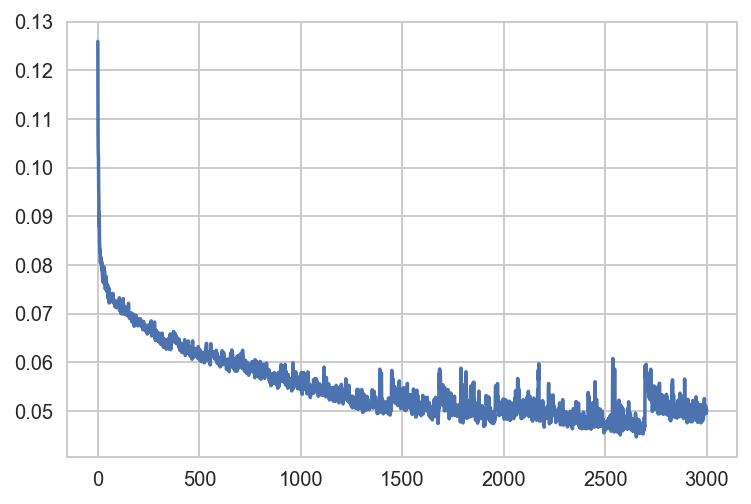

In [82]:
plt.plot(hist.history['loss'])
plt.show()

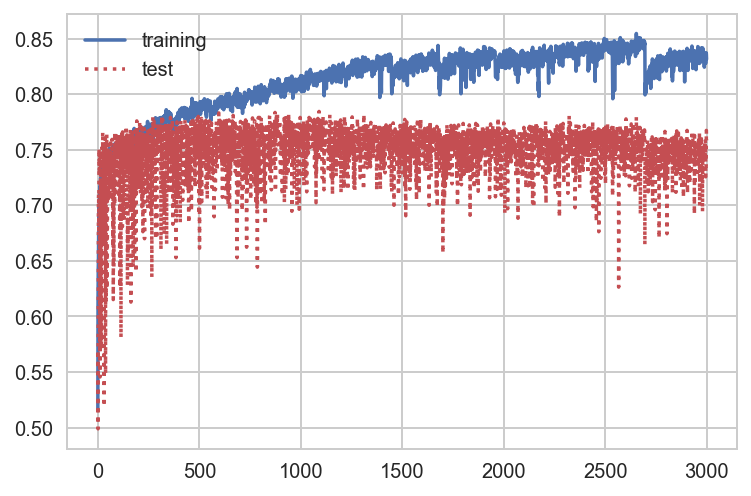

In [83]:
#자료가 좋으면 테스트가 더 높게 나올수도 있다.
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import *
y_pred = hist.model.predict_classes(df_final,verbose=0)
# print(y_pred)
print("- Accuracy_Score : ", accuracy_score(y, y_pred))
print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
# hist.model.predict_classes

- Accuracy_Score :  0.827824681157
- Confusion_Matrix 
 [[3783    2   24   59  404]
 [  15   41   16    0   75]
 [  68    4  316   15  307]
 [ 207    0   17  103  173]
 [ 406    2   79   44 4974]]


## 7. To improve performace
- AnimalType 별로 나눠서 EDA와 모델 만들어 비교할 예정
- 최적화
- 비대칭 데이터 해결

동물의 처리결과별 - 종 통계


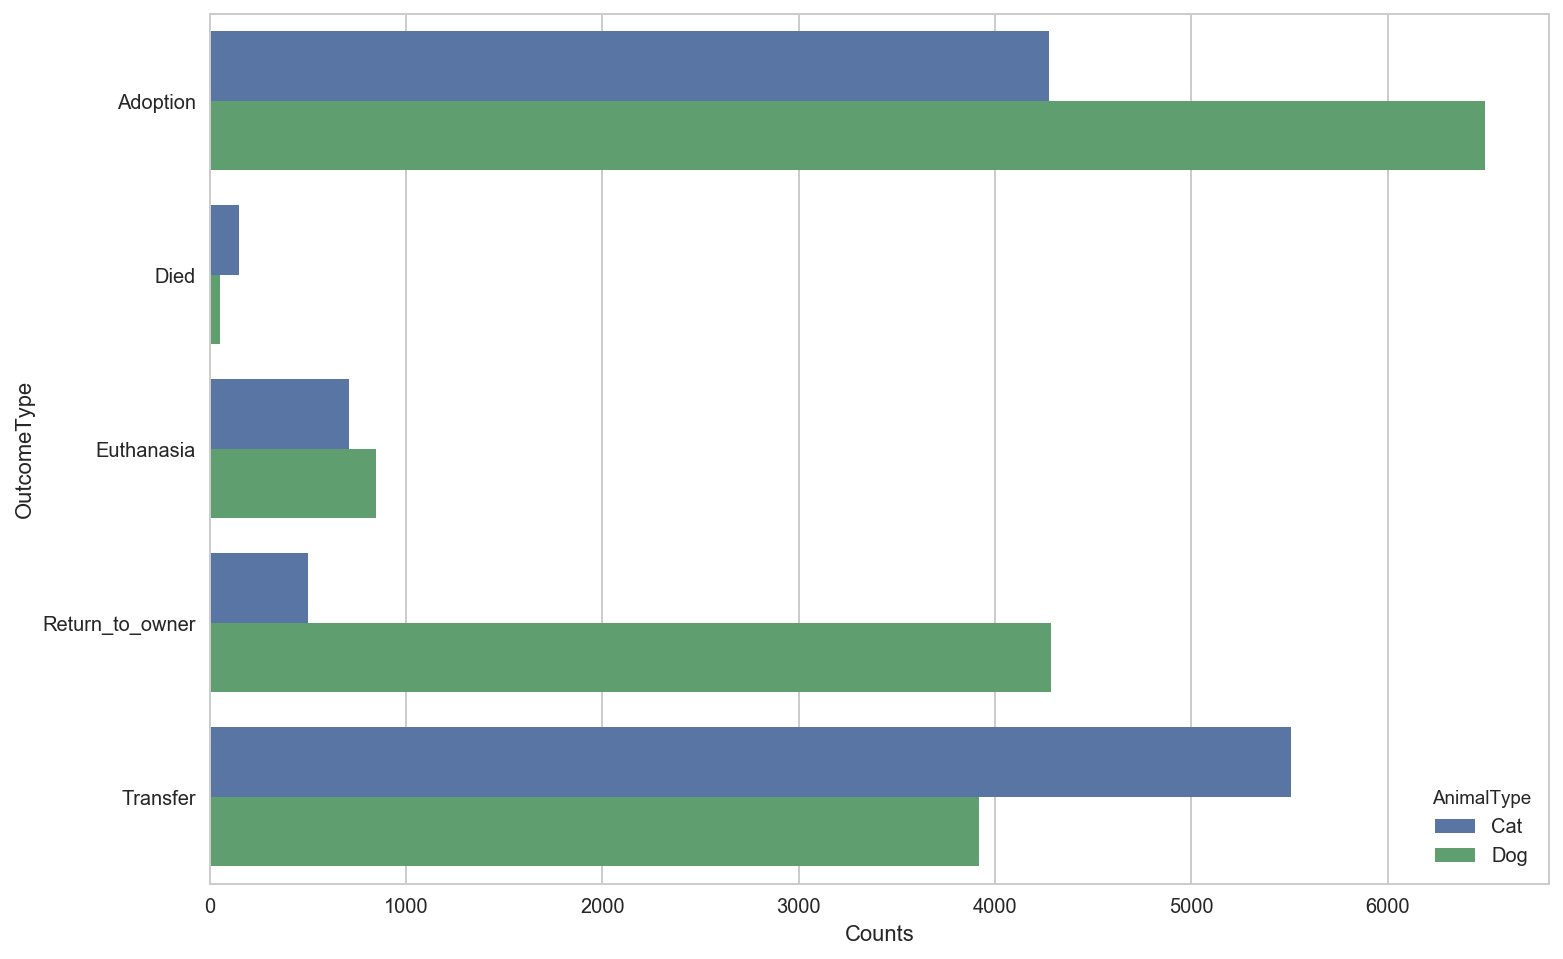

In [84]:
sorted_df = train.groupby(["OutcomeType","AnimalType"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeType", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("동물의 처리결과별 - 종 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

# 캐글점수용 submission 만들기

In [279]:
df_samplesub_animal = pd.read_csv("sample_submission.csv")
test= pd.read_csv("test.csv")

# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
# train["OutcomeSubtype"] = test["OutcomeSubtype"].fillna("NoStatus")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")

#사전조건 설정 (고양이 or 개)
test_if = test.copy()
# test_if = test[test["AnimalType"]=="Cat"].copy()
# test_if = test[test["AnimalType"]=="Dog"].copy()

#분석할 컬럼들
cols= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']
cols2=['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf',
       'Age_daily_scale', 'Age_code',
       'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM',
       'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
       'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']

tmp_test = preprocessShelter(test_if)
df_tcolors2, df_tbreeds2 = preprocessColorBreed(tmp_test)

df_OHEt = allOneHotEncoder(tmp_test,cols2)
df_Ctgt = allCategorizer(tmp_test,cols2)
# temp.head(20)
# df_train[cols]
df_test = pd.concat([df_Ctgt,df_tcolors2,df_tbreeds2],axis=1)
# cols_f = len(df_final.columns)

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

One_Hot_Encoding start... using  ['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_daily_scale', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , Complete!
Categorizing start... using  ['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_daily_scale', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , Complete!


In [306]:
# len()
list(df_tbreeds2.columns)
a=df_breeds2.describe().T.sort_values("mean",ascending=False)
a[a["mean"]<0.0004]

220

In [280]:
submit_proba = LGB_model.predict_proba(df_test)
submit_proba

ValueError: Number of features of the model must match the input. Model n_features_ is 250 and input n_features is 230 

In [116]:
submission = pd.DataFrame(submit_proba, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])

submission["ID"] = np.arange(1,len(resultA)+1)
submission = submission[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
submission.tail()

11456